In [1]:
#-*- coding:utf-8 -*-

import os
import sys
import time
import random
import math
import pickle
import unicodedata

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaussian(x, amplitude, mean, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime, timedelta
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from sklearn.preprocessing import StandardScaler

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import robject

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

rTE = importr('RTransferEntropy')
rTE.set_quiet(True)

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fa59428d6c0> [RTYPES.NILSXP]

In [3]:
from utils_p import *

In [4]:
# setup seed
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

SEED = 0
seed_everything(SEED)

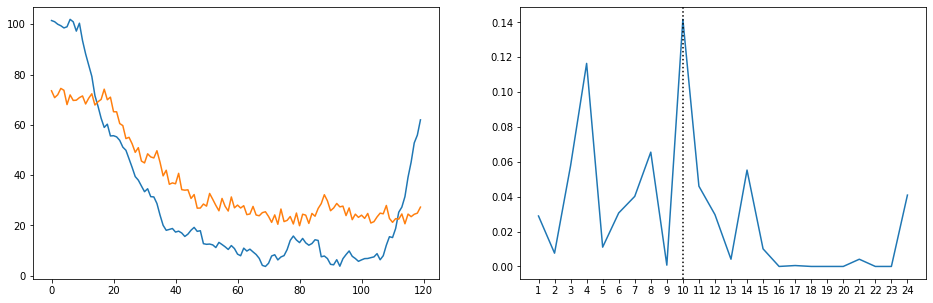

In [5]:
n = 120

while True:
    x = [100] * n + np.random.normal(0, 1, n)*2
    # for i in range(10): 
    #     x[i] = x[i] + np.random.normal(0, 10)

    for i in np.arange(10,n):
        if i < 100:
            x[i] = 0.95 * x[i-1] + np.random.normal(0,1)*2
        else: 
            x[i] = 1.10 * x[i-1] + np.random.normal(0,1)*2
    x = pd.Series(x)

    if np.min(x) > 0:
        break

lag = 10
k = 0

while True:
    random.seed(k)
    np.random.seed(k)
    
    y = [70] * n + np.random.normal(0, 1, n)*2
    for i in range(lag, n):
        y[i] = 0.5 * x[i-lag] + 20 + np.random.normal(0,1)*2
    y = pd.Series(y)

    out = []
    for lag_test in np.arange(1,25,1):
        x_copy = x.to_numpy().copy()
        y_copy = y.to_numpy().copy()

        ETE_value = rTE.calc_ete(x = x_copy[1:(len(x_copy)-lag_test)+1], y = y_copy[(lag_test):len(y_copy)],lx=1,ly=1)
        out.append([lag_test, np.asarray(ETE_value).item()])
        
    #check TE
    if lag == (np.argmax(np.array(out)[:,1])+1):
        fig, ax = plt.subplots(1, 2, figsize=(16,5))
        ax[0].plot(x)
        ax[0].plot(y)

        ax[1].plot(np.array(out)[:,0], np.array(out)[:,1])
        ax[1].set_xticks(np.arange(1,25))
        ax[1].axvline(lag, color='k', ls=':')

        plt.show()
        break
    
    k += 1

In [6]:
x.to_csv('x.csv')
y.to_csv('y.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

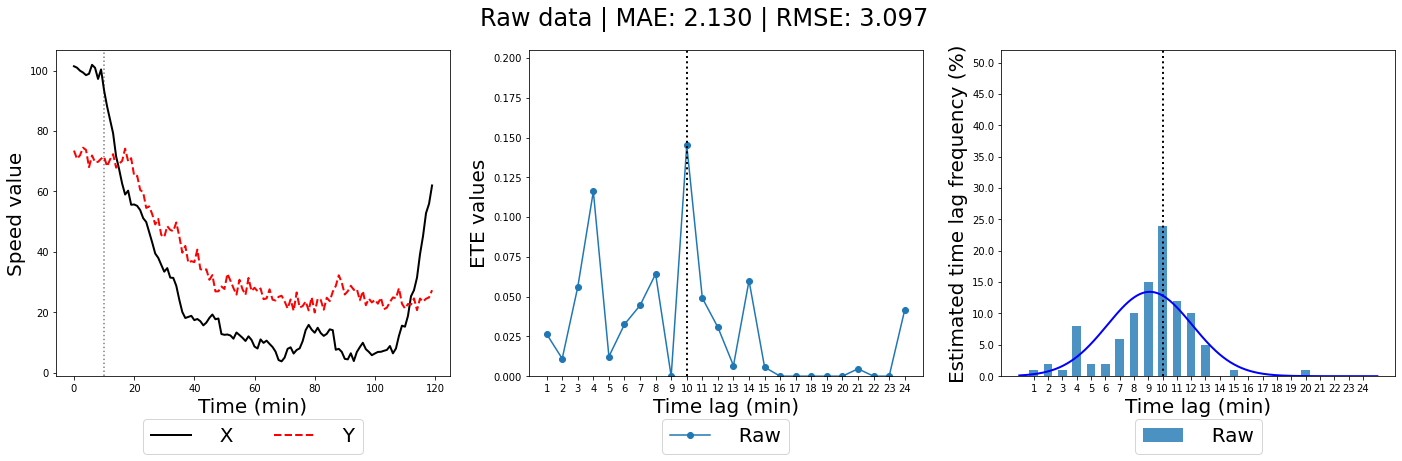

(9.11,
 2.13,
 3.0967725134404045,
 (8.327050618559564, 9.892949381440435),
 (9.11, 2.966125418791323))

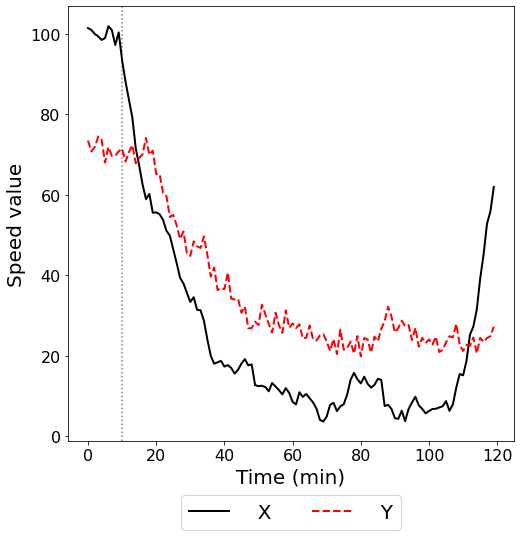

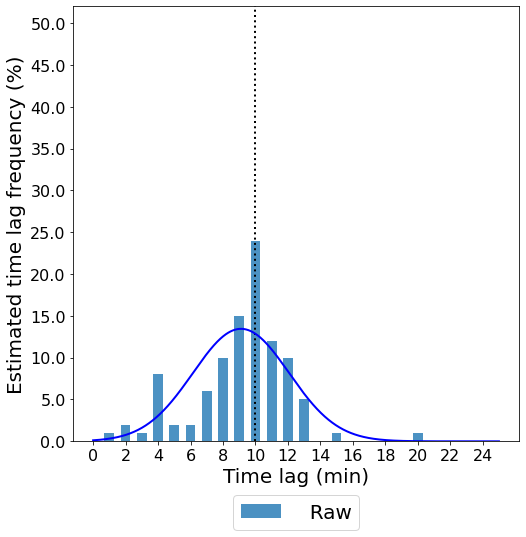

In [6]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x, y, lag=lag, plot=True, title = 'Raw data', save='raw', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [7]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [8]:
results = []
results.append(['raw', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

In [9]:
raw = [ETE_value, TE_boot_count, curve]

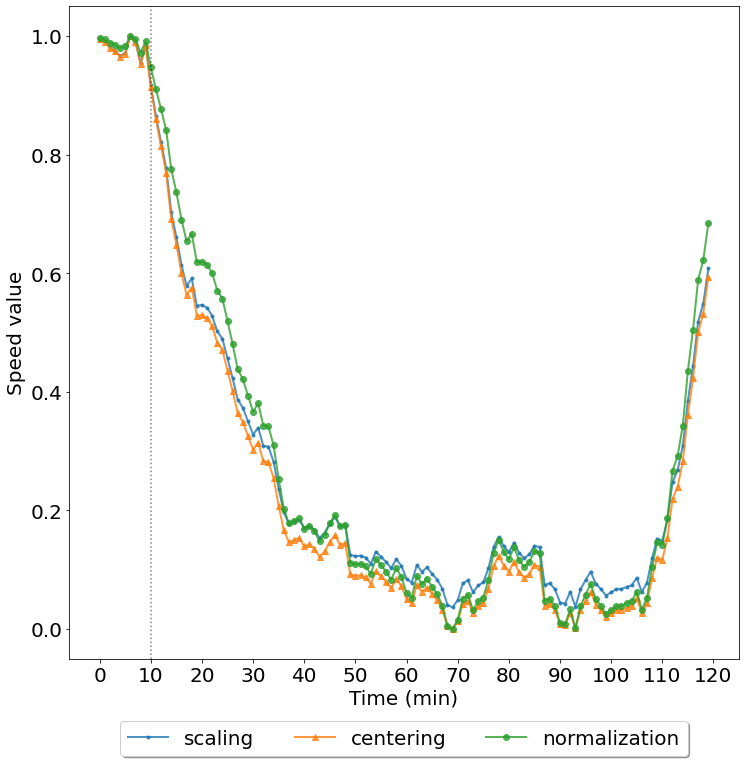

In [10]:
x_scaling = scaling(x)
x_centering = centering(x)
x_norm = normalization(x)
x_norm_scaled = normalization(x, scale=True)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_scaling, marker='.', label='min-max', lw=2, alpha=0.8)
ax.plot(x_centering, marker='^', label='z-score', lw=2, alpha=0.8)
ax.plot(x_norm_scaled, marker='o', label='nonlinaer', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('img/x.png', bbox_inches='tight')
plt.show()

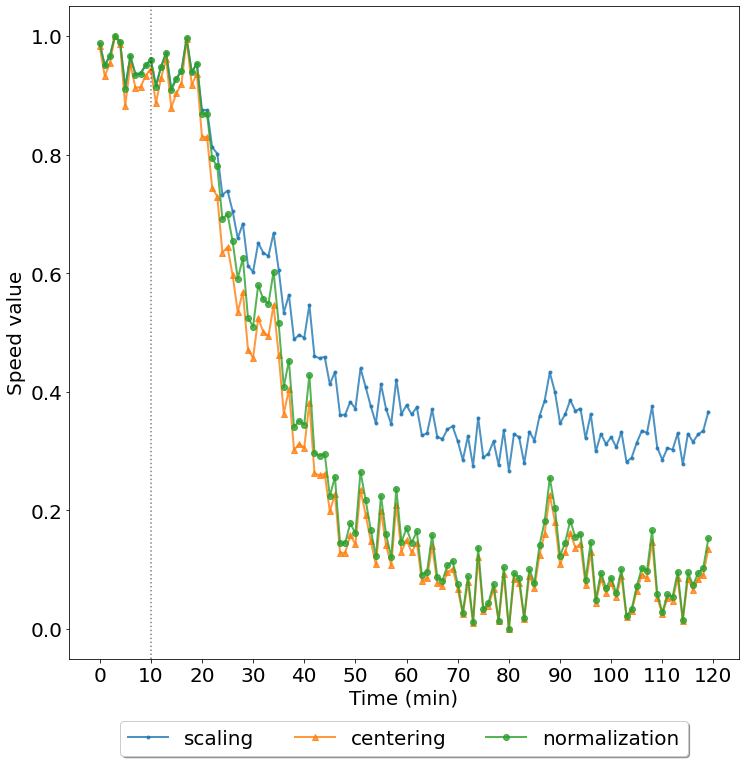

In [11]:
y_scaling = scaling(y)
y_centering = centering(y)
y_norm = normalization(y)
y_norm_scaled = normalization(y, scale=True)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_scaling, marker='.', label='min-max', lw=2, alpha=0.8)
ax.plot(y_centering, marker='^', label='z-score', lw=2, alpha=0.8)
ax.plot(y_norm_scaled, marker='o', label='nonlinear', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('img/y.png', bbox_inches='tight')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

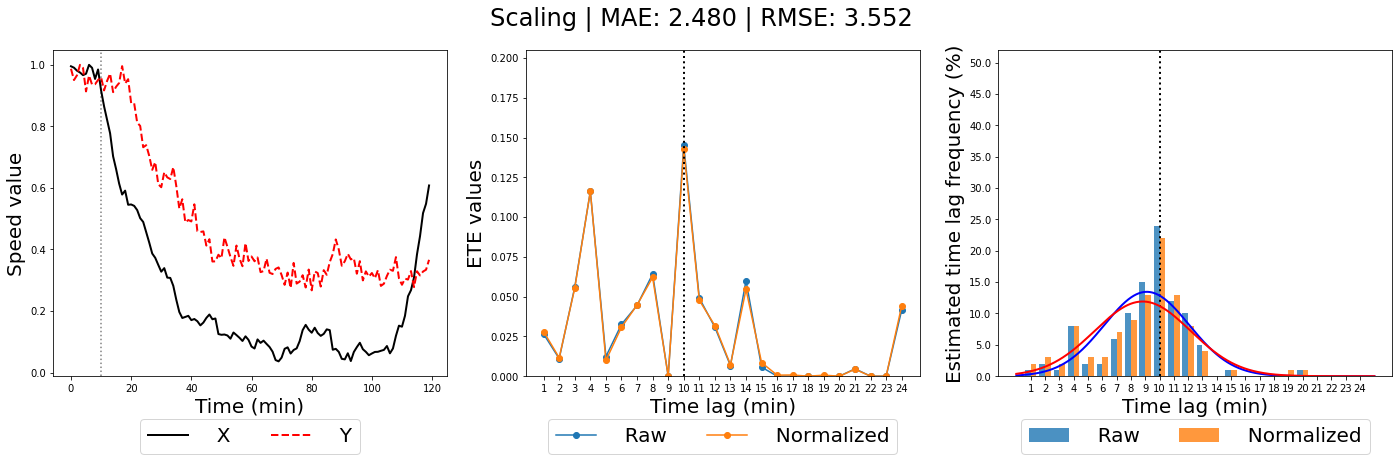

(8.82,
 2.48,
 3.552463933666322,
 (7.9355207666184215, 9.70447923338158),
 (8.82, 3.350761107569443))

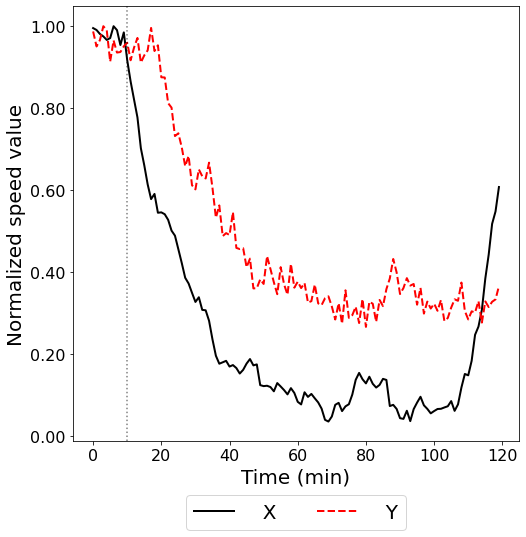

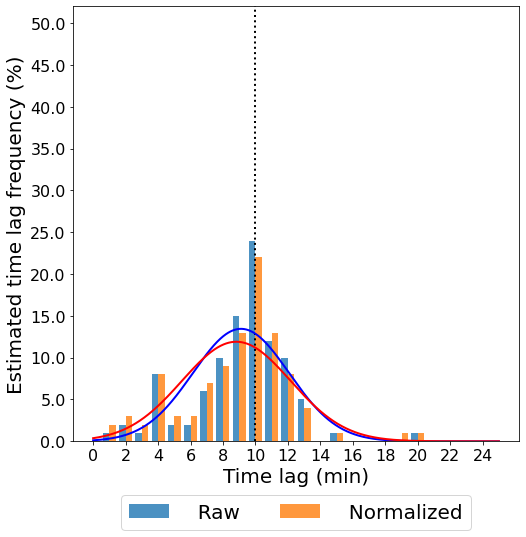

In [12]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_scaling,y_scaling, lag=lag, plot=True, title = 'Scaling', raw=raw, save='scale', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [13]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [14]:
results.append(['scale', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

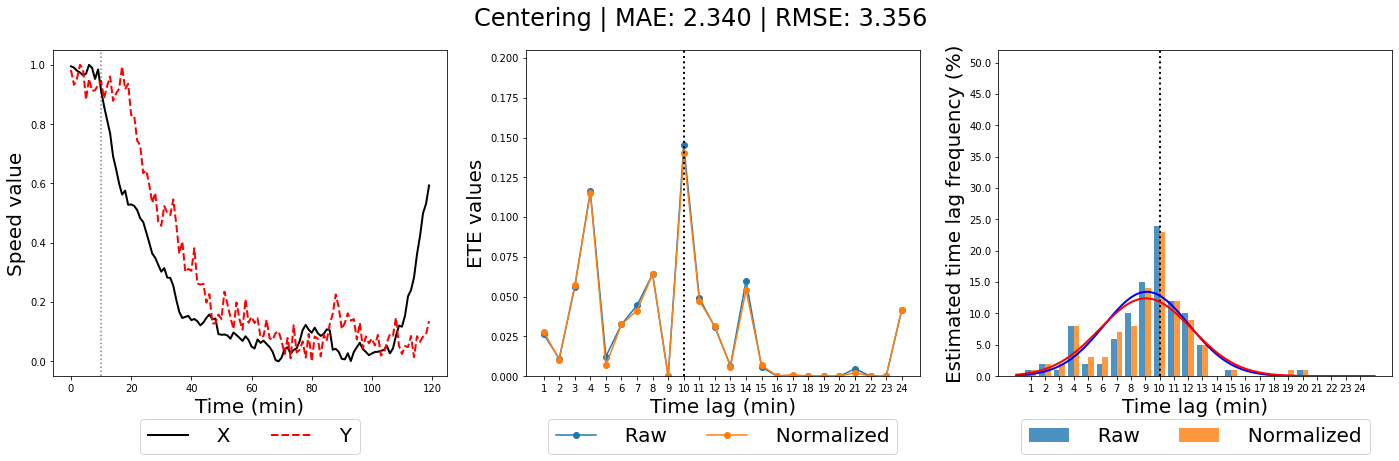

(9.04,
 2.34,
 3.3555923471125033,
 (8.191267485025275, 9.888732514974723),
 (9.04, 3.215338240372232))

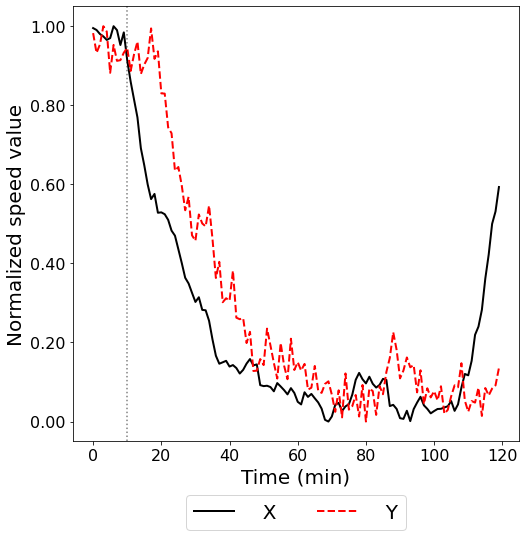

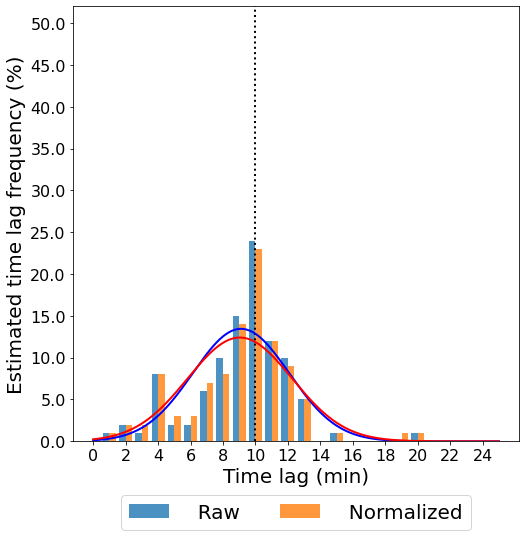

In [15]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_centering,y_centering, lag=lag, plot=True, title = 'Centering', raw=raw, save='center', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [16]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [17]:
results.append(['center', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

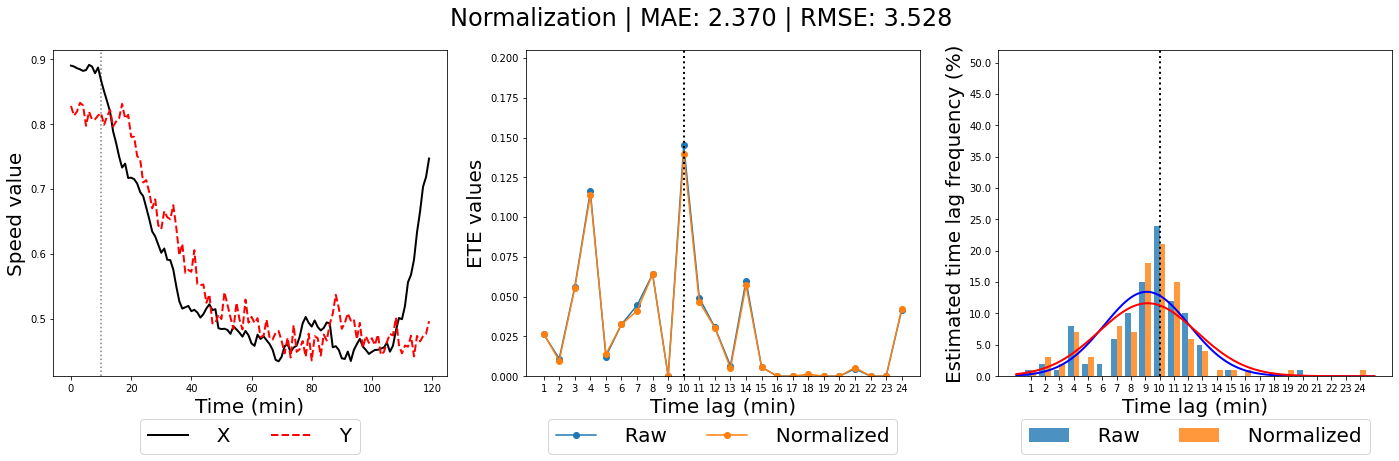

(9.17,
 2.37,
 3.52845575287547,
 (8.264750807715608, 10.075249192284392),
 (9.17, 3.4294460194031338))

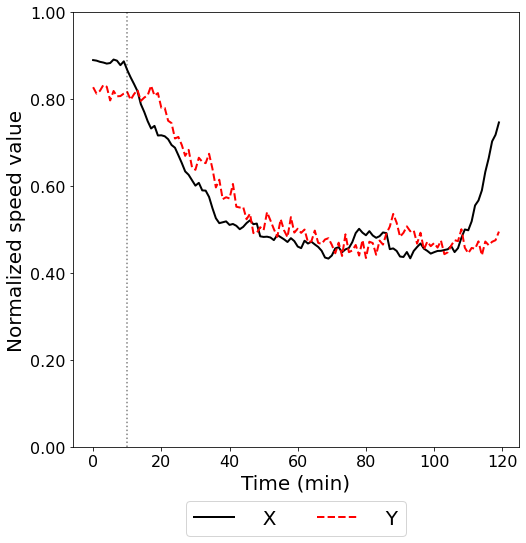

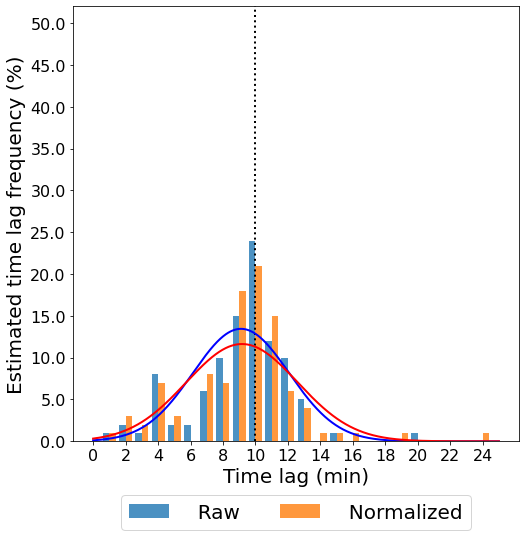

In [18]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm,y_norm, lag=lag, plot=True, 
                                                                       title = 'Normalization', raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

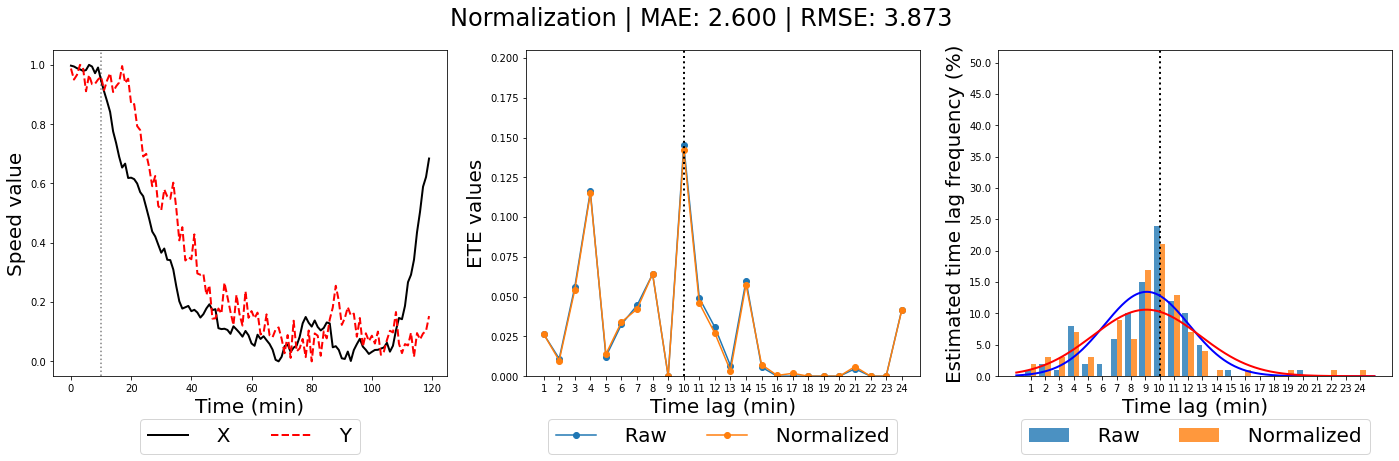

(9.08,
 2.6,
 3.872983346207417,
 (8.086935096457932, 10.073064903542068),
 (9.08, 3.7621270579287995))

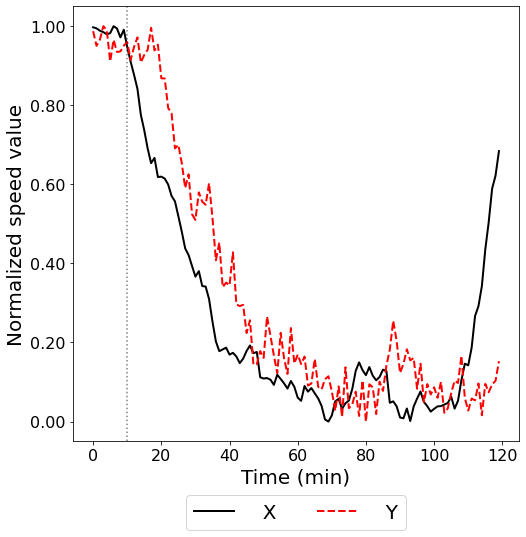

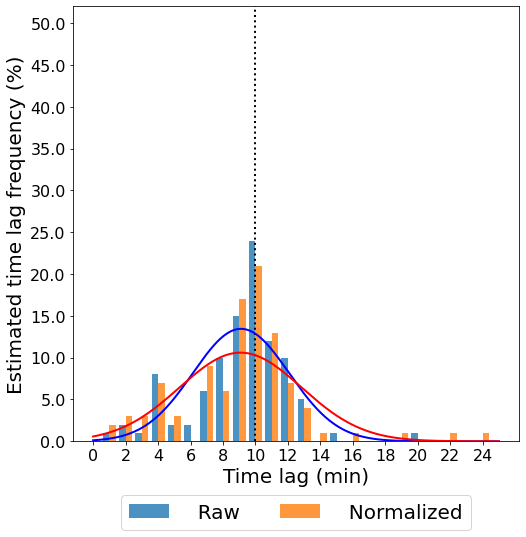

In [19]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                       title = 'Normalization', raw=raw, save='norm', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [20]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [21]:
results.append(['norm', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

In [22]:
period = 60

In [23]:
x_pre = [100] * period + np.random.normal(0, 1, period)*2
x = pd.Series(np.append(x_pre, x.to_numpy()))

In [24]:
y_pre = [70] * period + np.random.normal(0, 1, period)*2
y = pd.Series(np.append(y_pre, y.to_numpy()))

In [25]:
out = []
for lag_test in np.arange(1,25,1):
    x_copy = x.to_numpy().copy()
    y_copy = y.to_numpy().copy()

    ETE_value = rTE.calc_ete(x = x_copy[1:(len(x_copy)-lag_test)+1], y = y_copy[(lag_test):len(y_copy)],lx=1,ly=1)
    out.append([lag_test, np.asarray(ETE_value).item()])

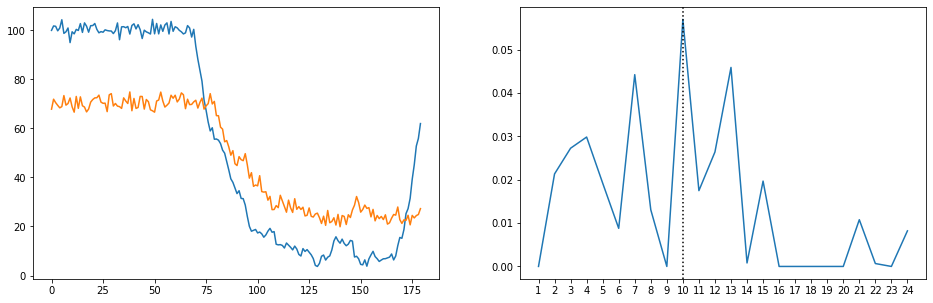

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(x)
ax[0].plot(y)

ax[1].plot(np.array(out)[:,0], np.array(out)[:,1])
ax[1].set_xticks(np.arange(1,25))
ax[1].axvline(lag, color='k', ls=':')

plt.show()

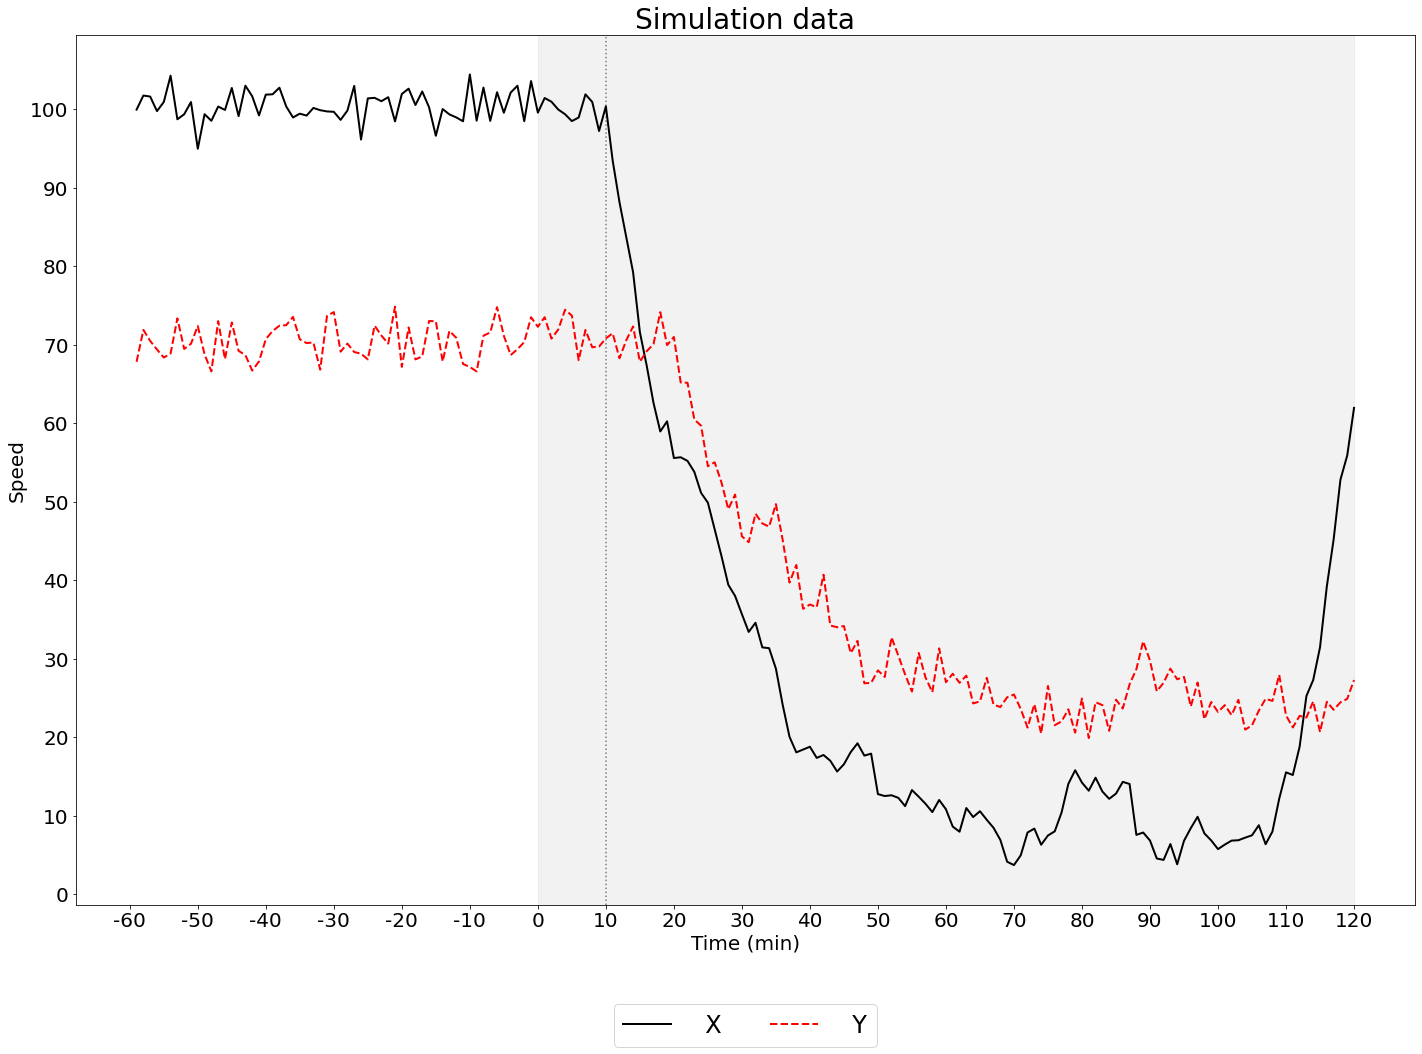

In [27]:
fig, ax = plt.subplots(1,1, figsize=(24,16)) 
ax.plot(x, color='k', lw=2)
ax.plot(y, color='r', ls='dashed', lw=2)

# ax.axvline(60-1, color='b', ls = ':', alpha=0.5)
# ax.axvline(180-1, color='b', ls = ':', alpha=0.5)
ax.axvspan(60-1, 180-1, alpha=0.1, color='gray')
ax.axvline(70-1, color='k', ls = ':', alpha=0.5)
plt.legend(['  X','  Y'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=24)

plt.title('Simulation data', fontsize=28)

ax.set_xticks(np.arange(-1, 180, 10))
ax.set_xticklabels(list(np.arange(-60,121, 10)), fontsize=20)
ax.set_yticks(np.arange(0, 110, 10))
ax.set_yticklabels(np.arange(0, 110, 10), fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed', fontsize=20)

plt.savefig('img/fig.png', bbox_inches='tight')
plt.show()

In [28]:
period=10

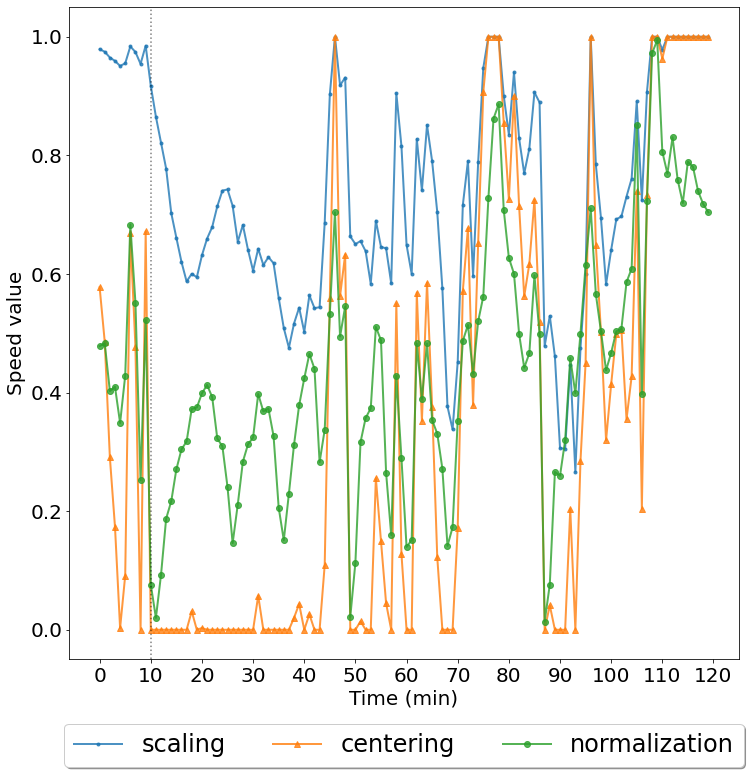

In [29]:
x_scaling = scaling(x, period=period)[-120:]
x_centering = centering(x, period=period)[-120:]
x_norm = normalization(x, period=period)[-120:]
x_norm_scaled = normalization(x, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(x_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(x_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=24)
plt.savefig('img/x_p.png', bbox_inches='tight')
plt.show()

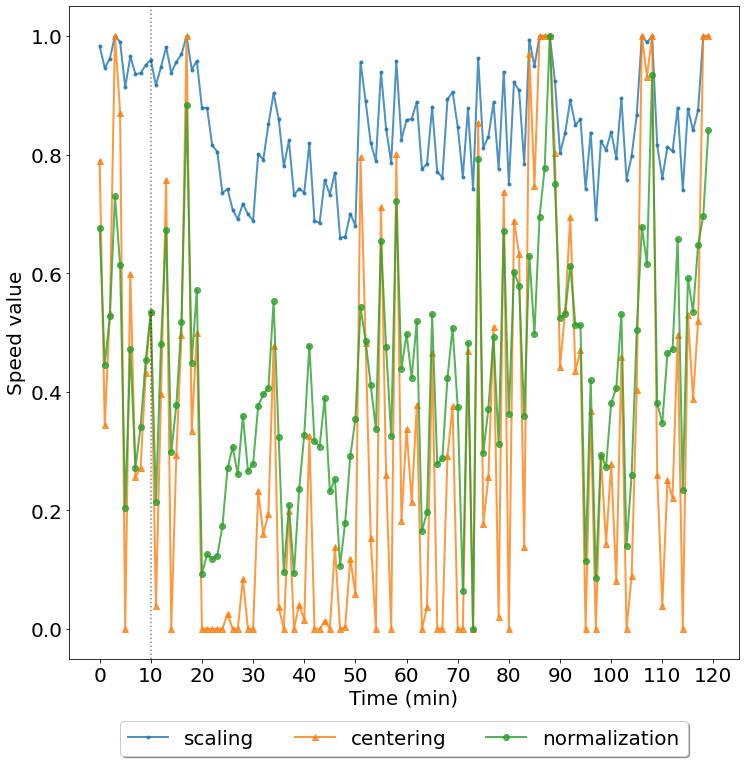

In [30]:
y_scaling = scaling(y, period=period)[-120:]
y_centering = centering(y, period=period)[-120:]
y_norm = normalization(y, period=period)[-120:]
y_norm_scaled = normalization(y, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(y_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(y_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('img/y_p.png', bbox_inches='tight')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

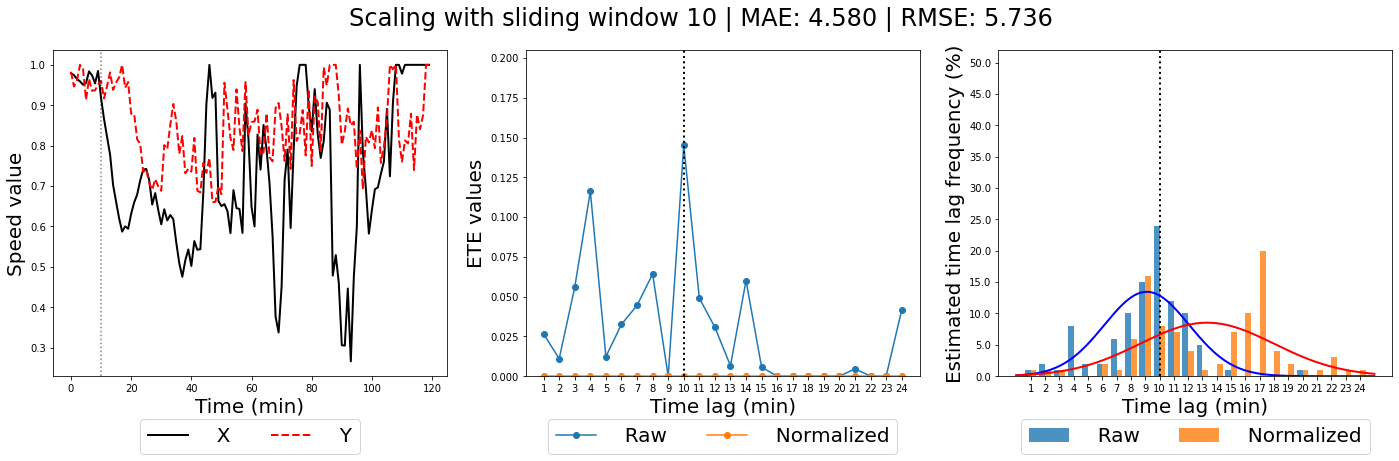

(13.32,
 4.58,
 5.735852159879995,
 (12.08534956576379, 14.55465043423621),
 (13.32, 4.677349676900371))

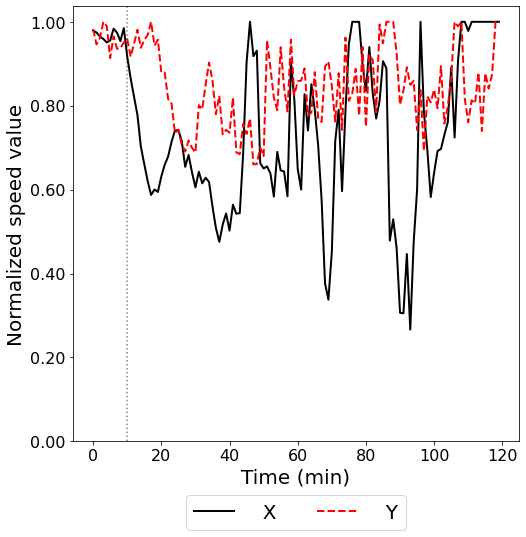

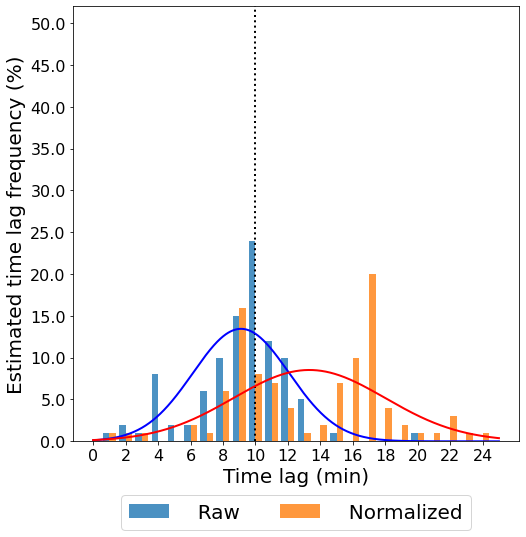

In [31]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_scaling,y_scaling, lag=lag, plot=True, 
                                                                               title = 'Scaling with sliding window {}'.format(period), raw=raw, save='scale_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [32]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [33]:
results.append(['scale_p_10', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

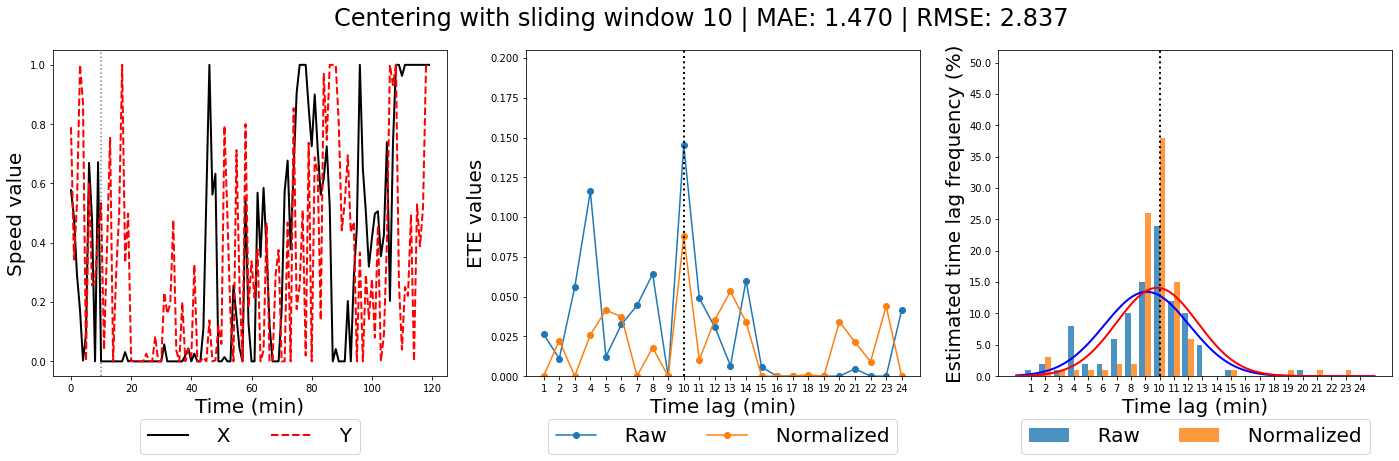

(9.83,
 1.47,
 2.8372521918222215,
 (9.082414033933835, 10.577585966066165),
 (9.83, 2.832154656794011))

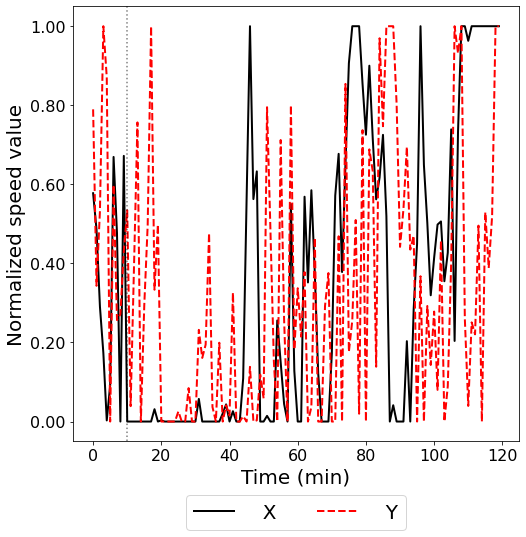

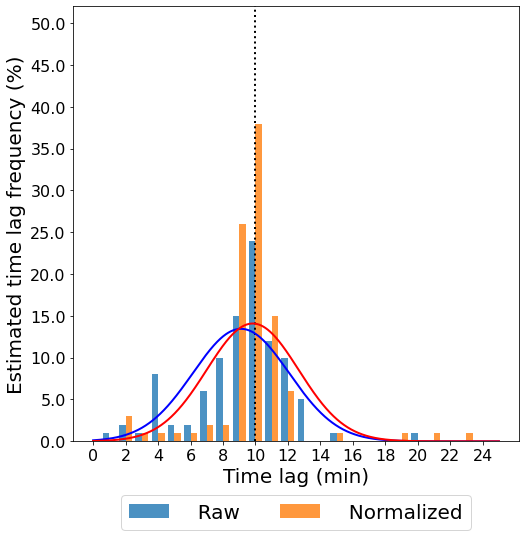

In [34]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_centering,y_centering, lag=lag, plot=True, 
                                                                               title = 'Centering with sliding window {}'.format(period), raw=raw, save='center_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [35]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [36]:
results.append(['center_p_10', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

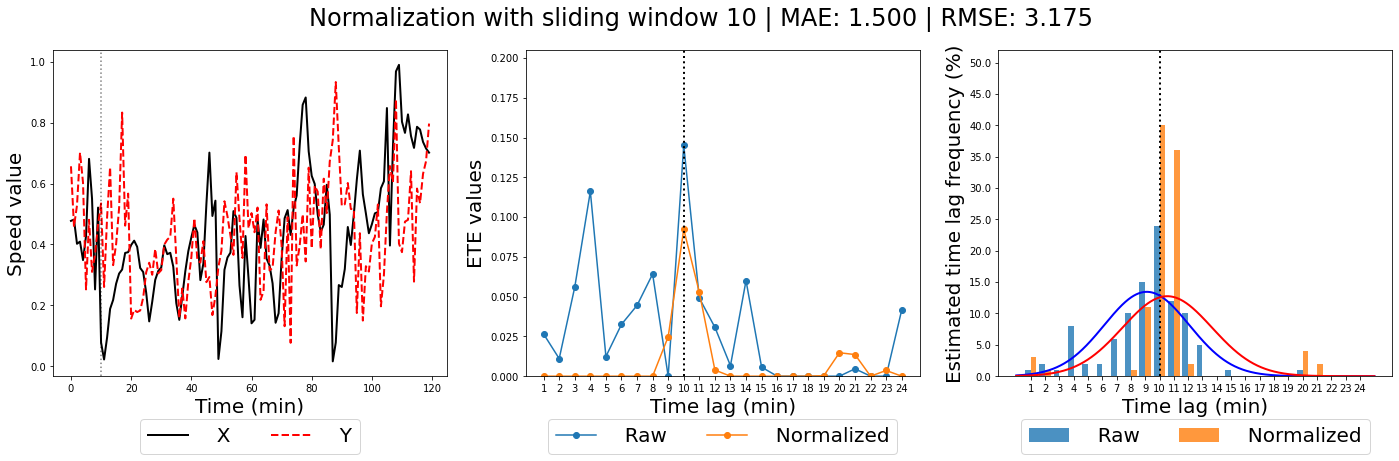

(10.54,
 1.5,
 3.1749015732775088,
 (9.714152175928586, 11.365847824071412),
 (10.54, 3.128641877876086))

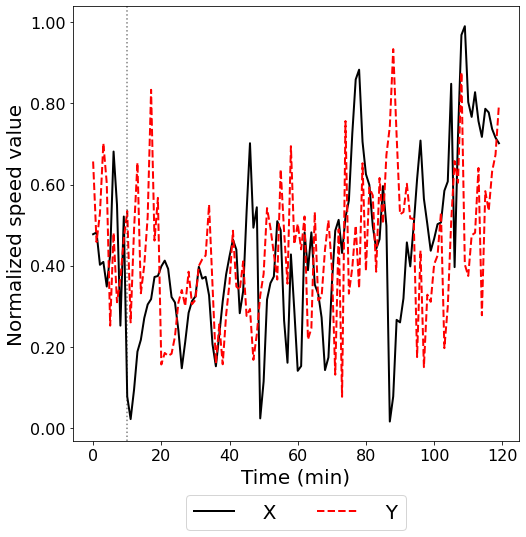

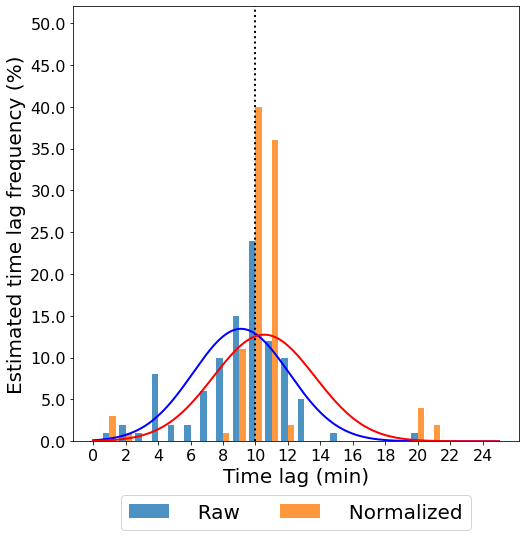

In [37]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm,y_norm, plot=True, lag=lag, 
                                                                               title = 'Normalization with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

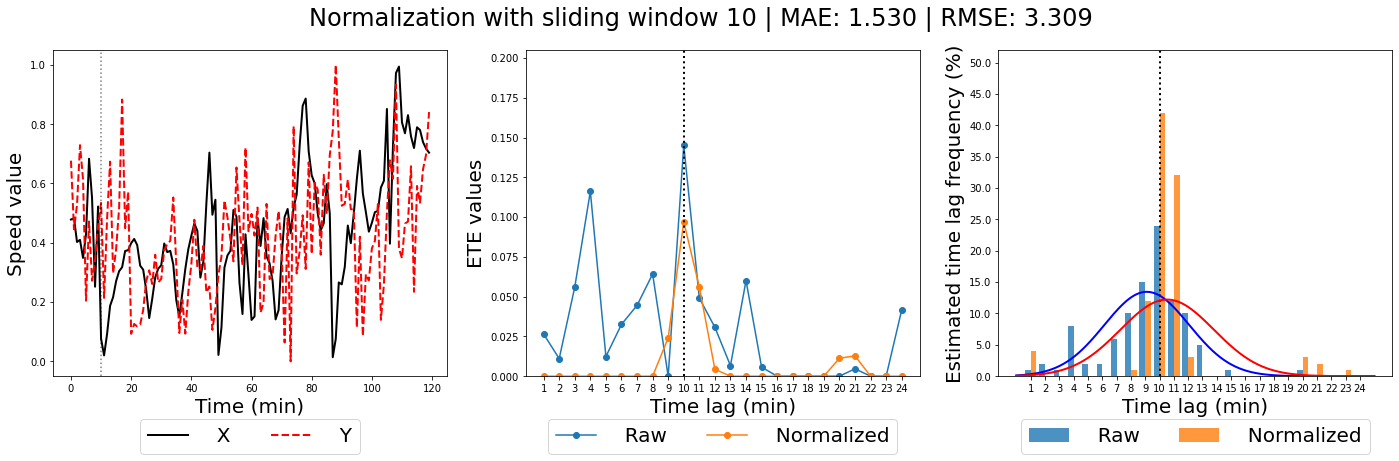

(10.53,
 1.53,
 3.3090784215548594,
 (9.667799902677144, 11.392200097322855),
 (10.53, 3.2663588290327197))

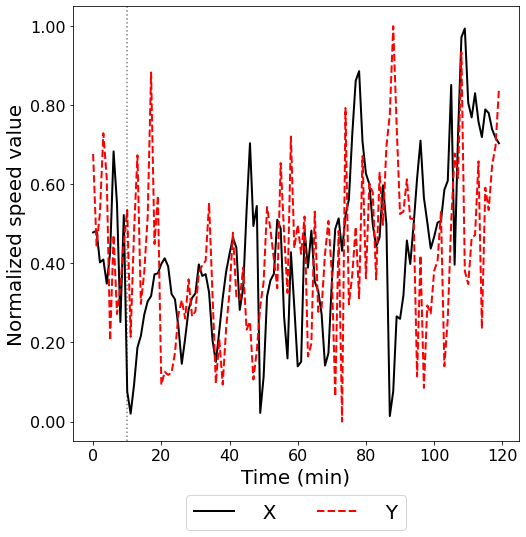

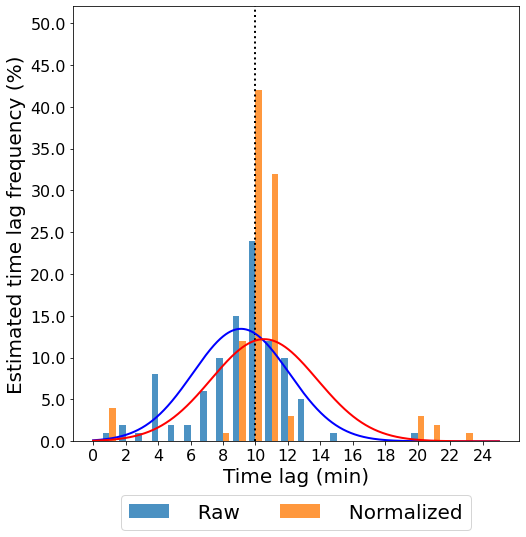

In [38]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                               title = 'Normalization with sliding window {}'.format(period), raw=raw, save='norm_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [39]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [40]:
results.append(['norm_p_10', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

In [41]:
period=20

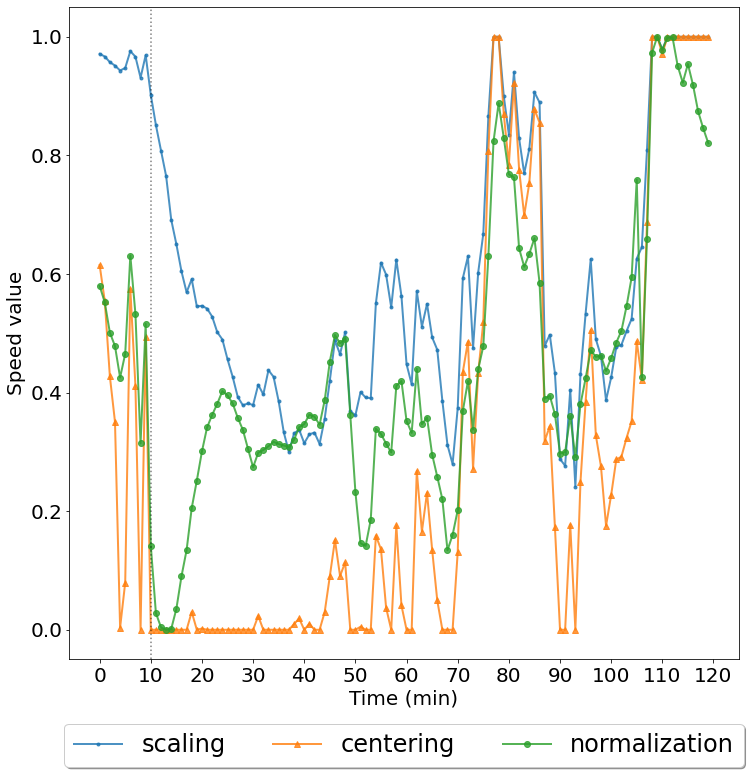

In [42]:
x_scaling = scaling(x, period=period)[-120:]
x_centering = centering(x, period=period)[-120:]
x_norm = normalization(x, period=period)[-120:]
x_norm_scaled = normalization(x, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(x_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(x_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=24)
plt.savefig('img/x_p.png', bbox_inches='tight')
plt.show()

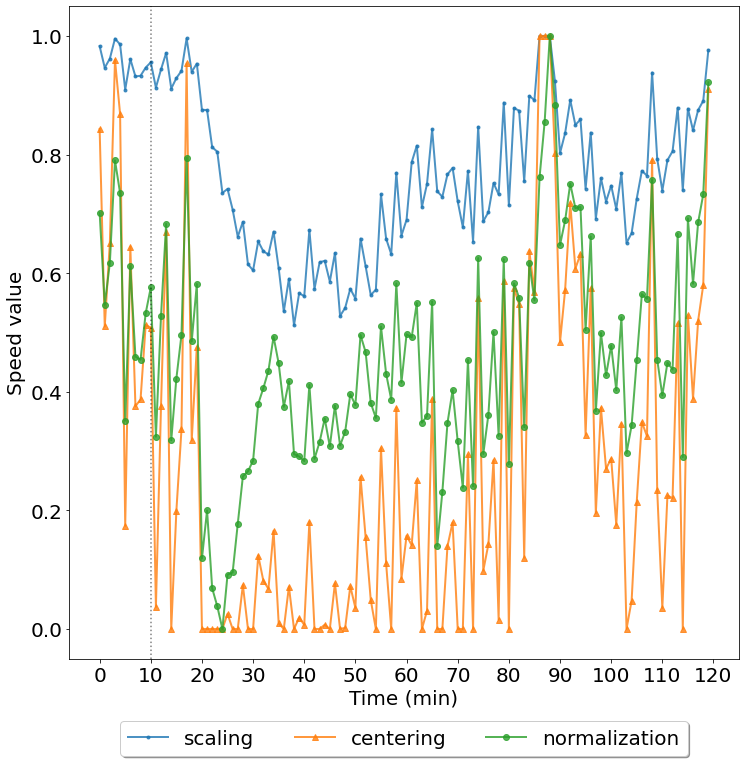

In [43]:
y_scaling = scaling(y, period=period)[-120:]
y_centering = centering(y, period=period)[-120:]
y_norm = normalization(y, period=period)[-120:]
y_norm_scaled = normalization(y, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(y_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(y_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.savefig('img/y_p.png', bbox_inches='tight')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

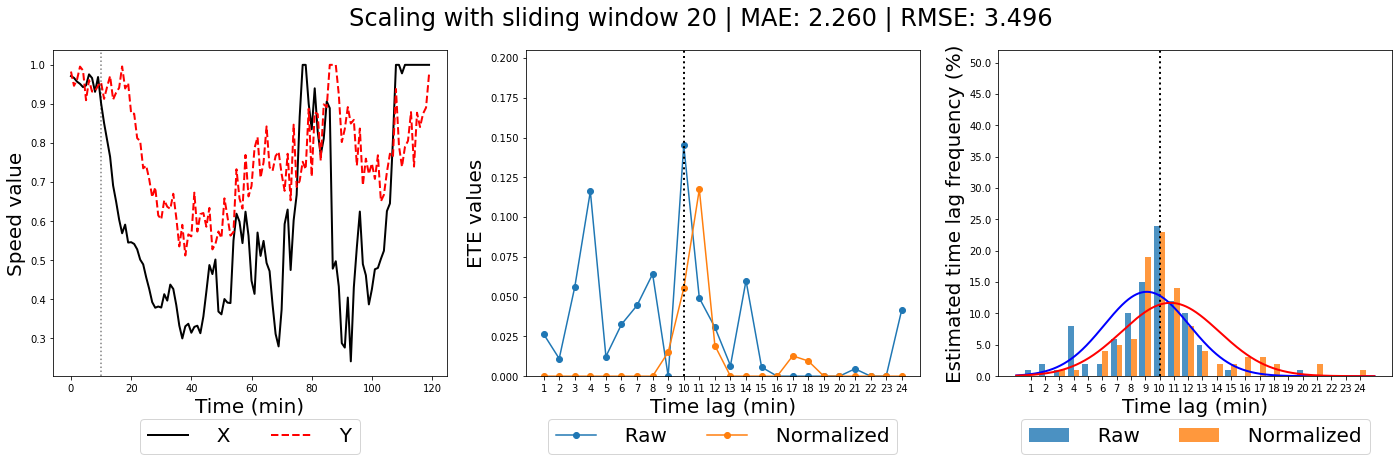

(10.76,
 2.26,
 3.4957116585897072,
 (9.859330548387259, 11.66066945161274),
 (10.76, 3.4120961299471033))

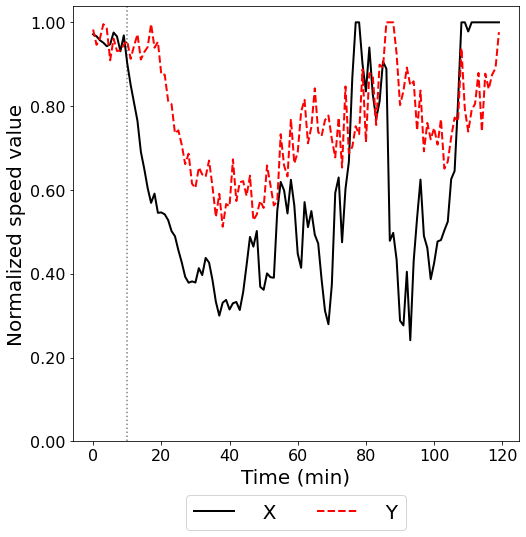

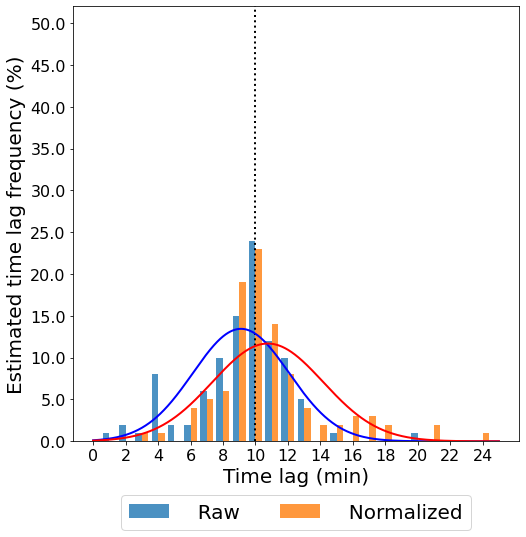

In [44]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_scaling,y_scaling, lag=lag, plot=True, 
                                                                               title = 'Scaling with sliding window {}'.format(period), raw=raw, save='scale_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [45]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [46]:
results.append(['scale_p_20', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

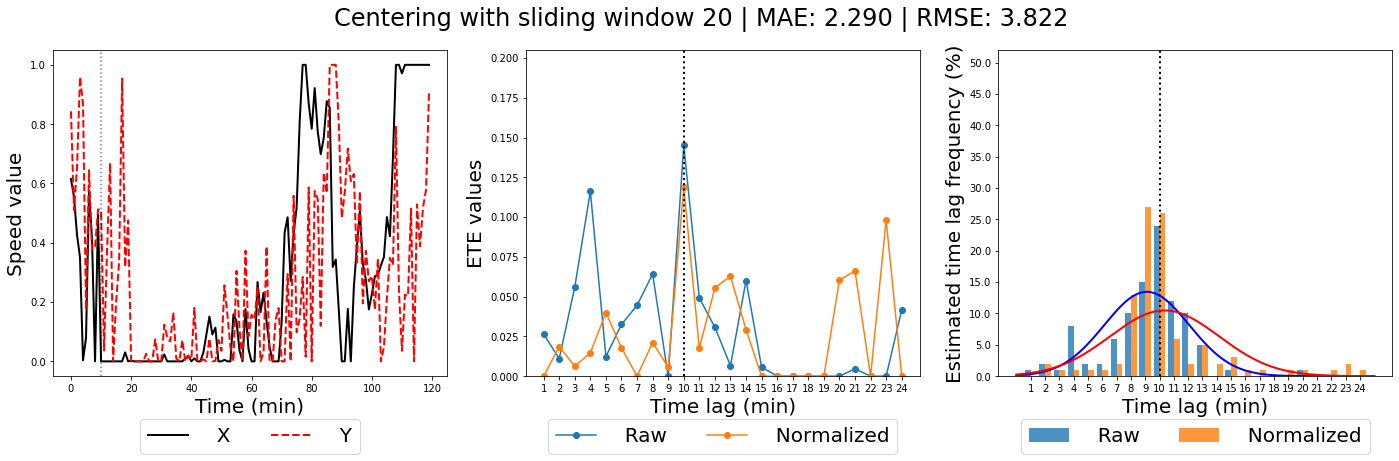

(10.35,
 2.29,
 3.8223029707232783,
 (9.345289596782486, 11.354710403217513),
 (10.35, 3.806244868633651))

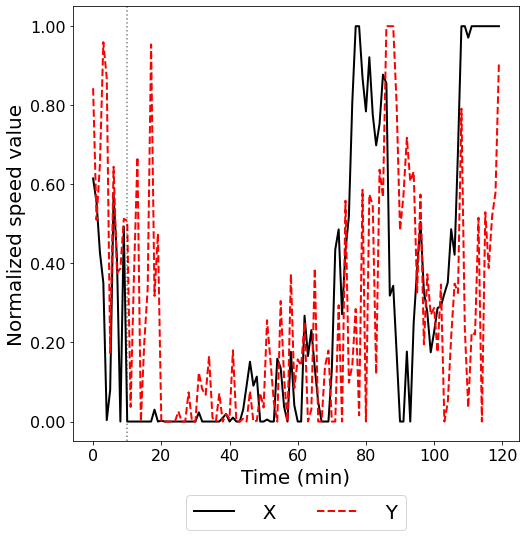

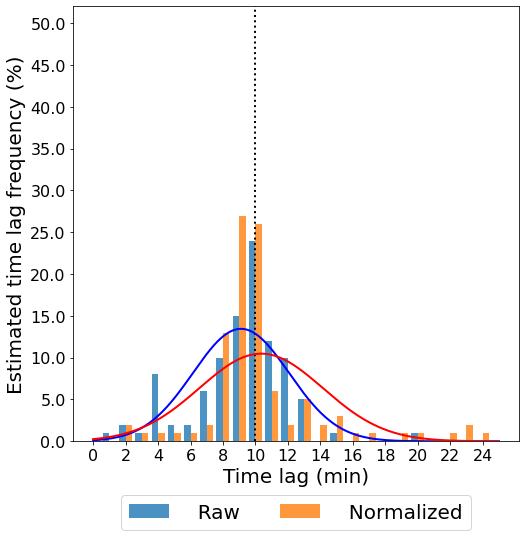

In [47]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_centering,y_centering, lag=lag, plot=True, 
                                                                               title = 'Centering with sliding window {}'.format(period), raw=raw, save='center_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [48]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [49]:
results.append(['center_p_20', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

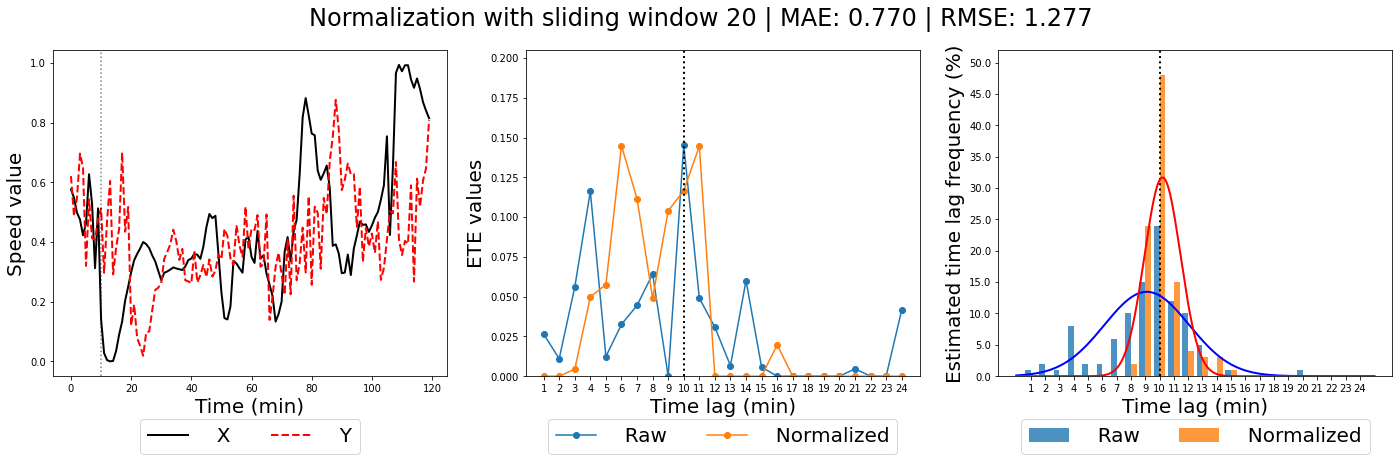

(10.21,
 0.77,
 1.2767145334803705,
 (9.877583881396001, 10.542416118604),
 (10.21, 1.2593252161375947))

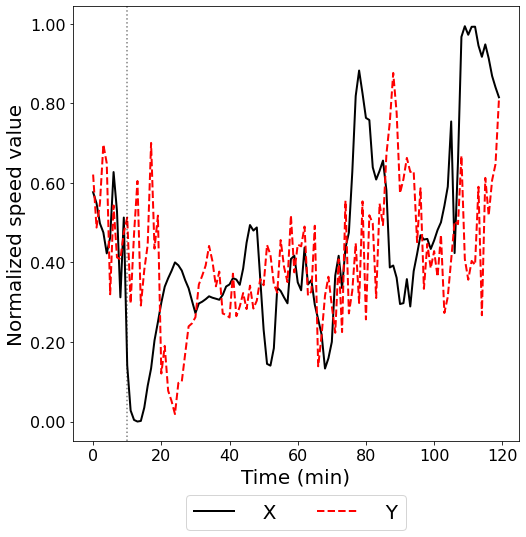

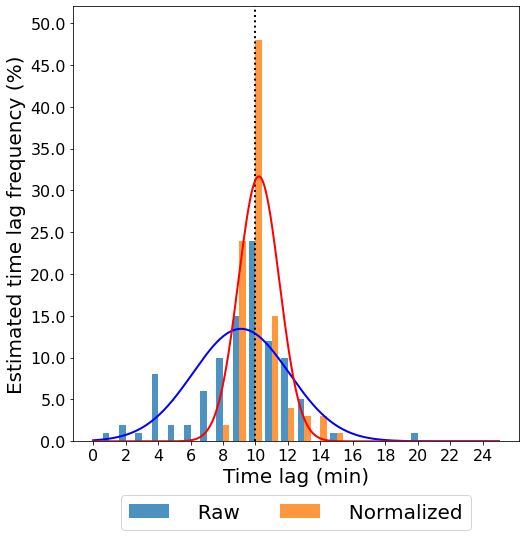

In [50]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm,y_norm, plot=True, lag=lag, 
                                                                               title = 'Normalization with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

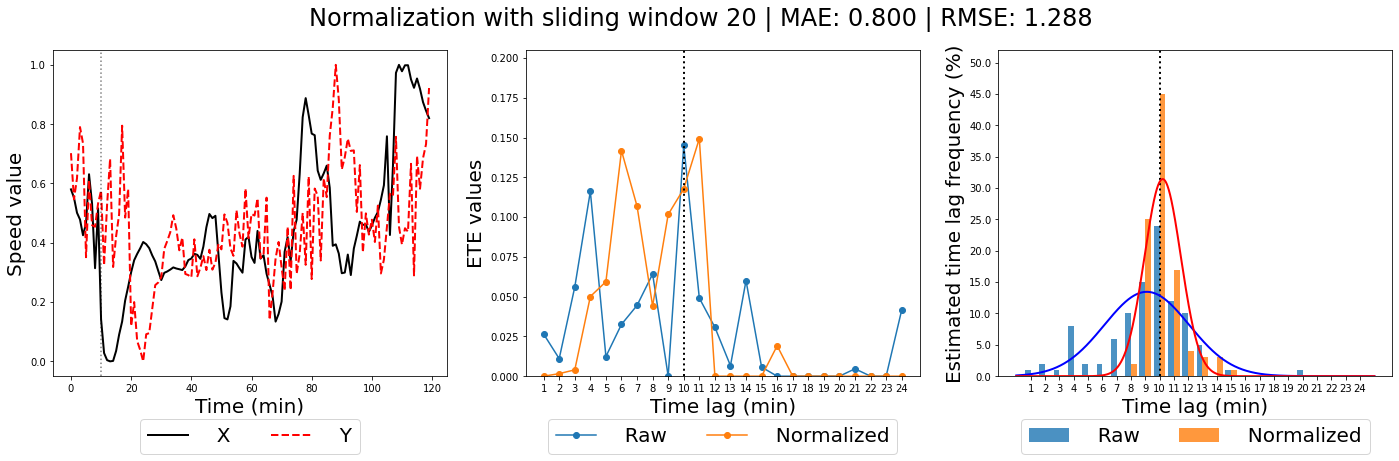

(10.22,
 0.8,
 1.2884098726725126,
 (9.88490125291742, 10.555098747082582),
 (10.22, 1.269488085804668))

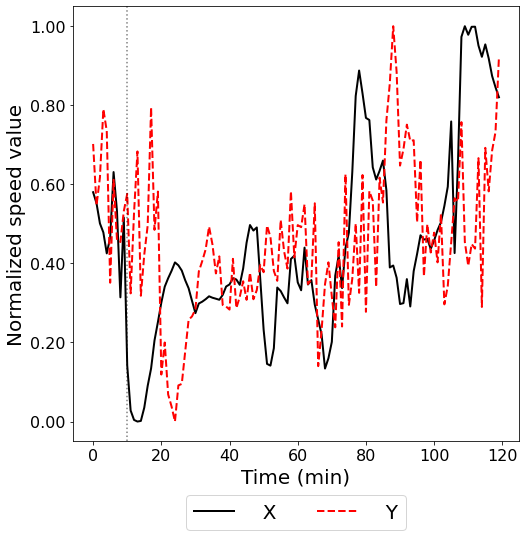

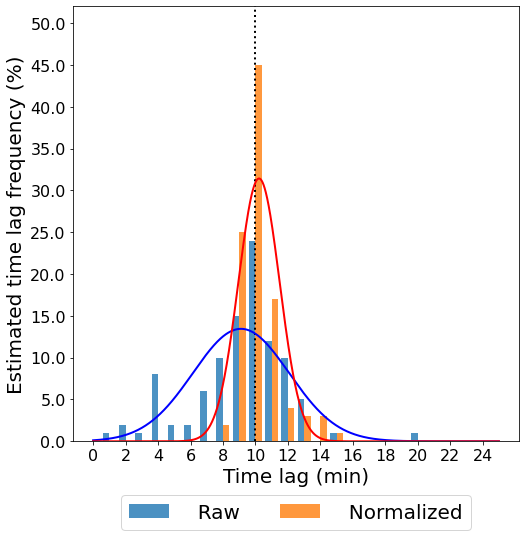

In [51]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve  = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                               title = 'Normalization with sliding window {}'.format(period), raw=raw, save='norm_p', curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [52]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [53]:
results.append(['norm_p_20', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

In [54]:
period=30

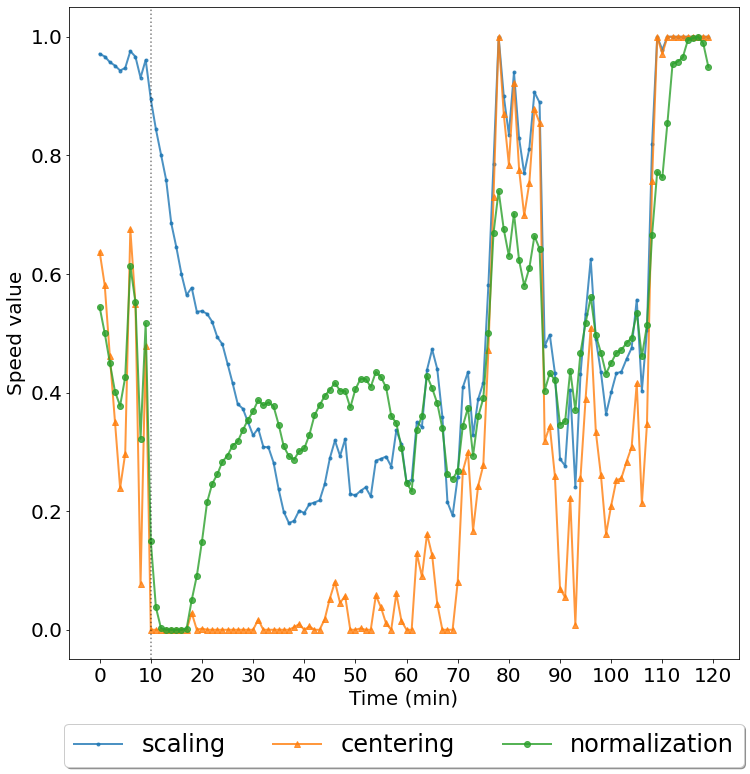

In [55]:
x_scaling = scaling(x, period=period)[-120:]
x_centering = centering(x, period=period)[-120:]
x_norm = normalization(x, period=period)[-120:]
x_norm_scaled = normalization(x, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(x_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(x_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=24)
plt.show()

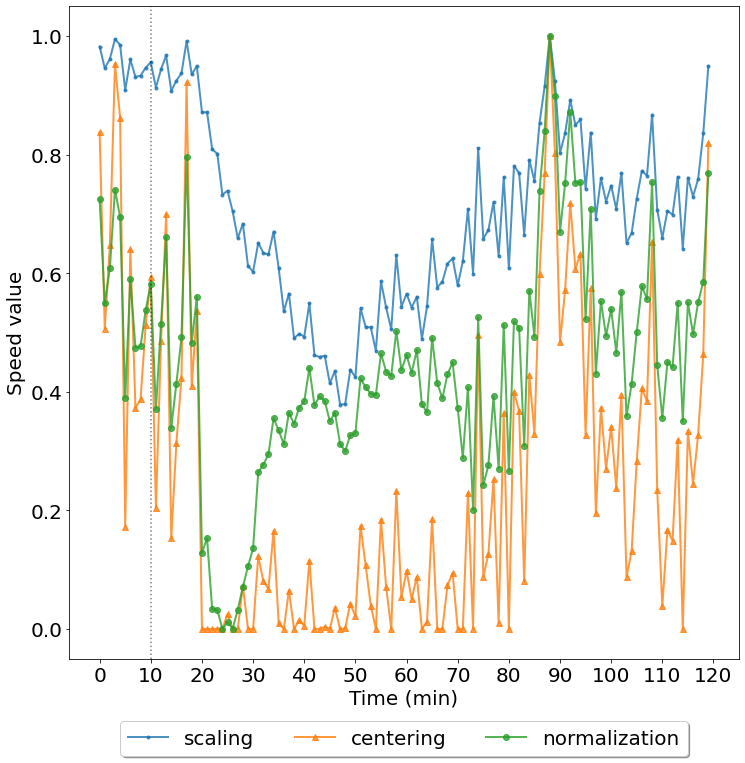

In [56]:
y_scaling = scaling(y, period=period)[-120:]
y_centering = centering(y, period=period)[-120:]
y_norm = normalization(y, period=period)[-120:]
y_norm_scaled = normalization(y, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(y_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(y_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

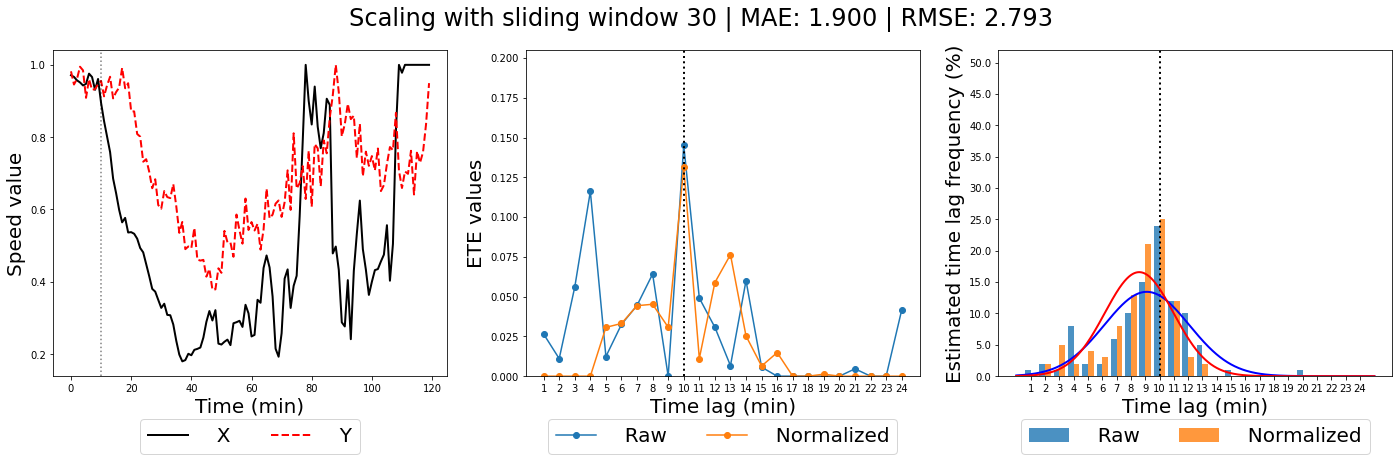

(8.58,
 1.9,
 2.792848008753788,
 (7.9451906727728545, 9.214809327227146),
 (8.58, 2.4049116407884927))

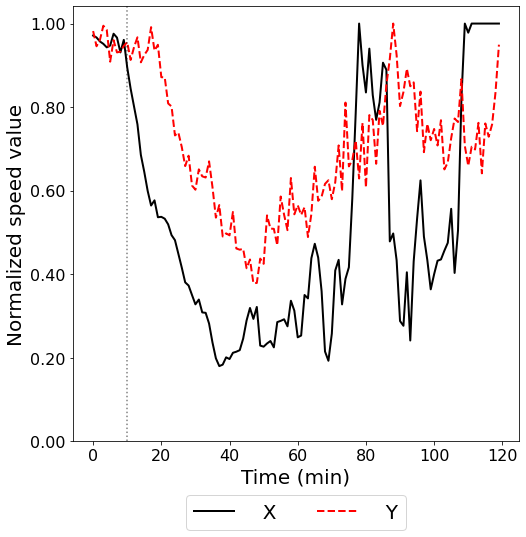

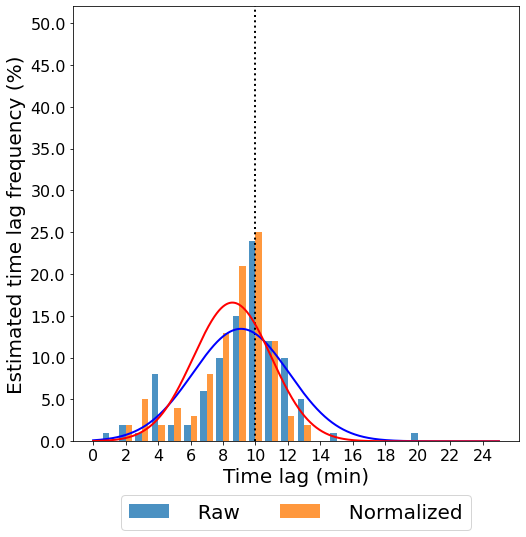

In [57]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_scaling,y_scaling, lag=lag, plot=True, 
                                                                              title = 'Scaling with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [58]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [59]:
results.append(['scale_p_30', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

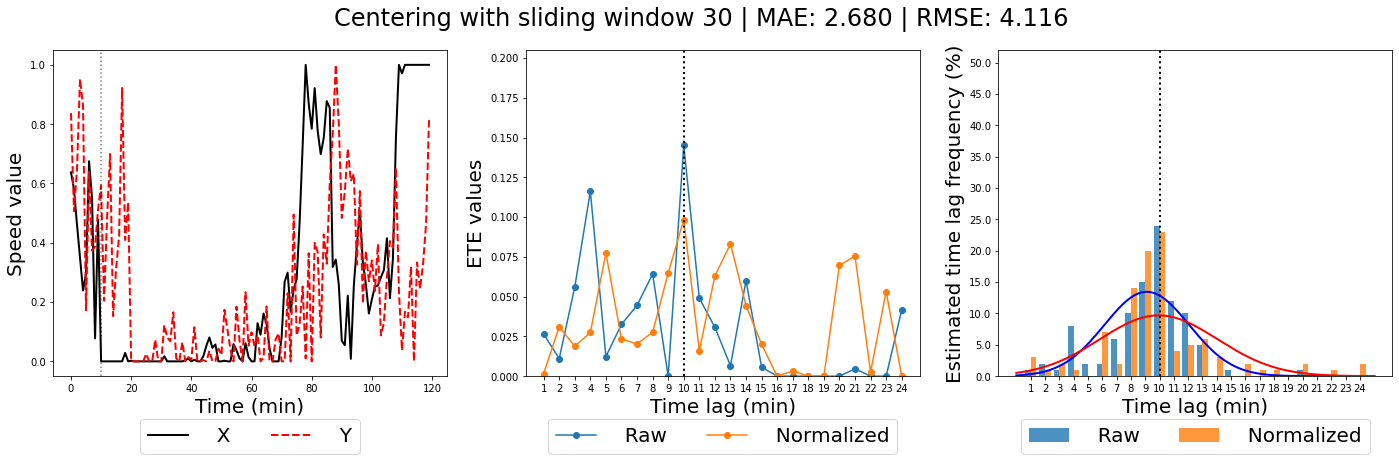

(9.94,
 2.68,
 4.115823125451335,
 (8.853687627913407, 11.026312372086592),
 (9.94, 4.115385765636072))

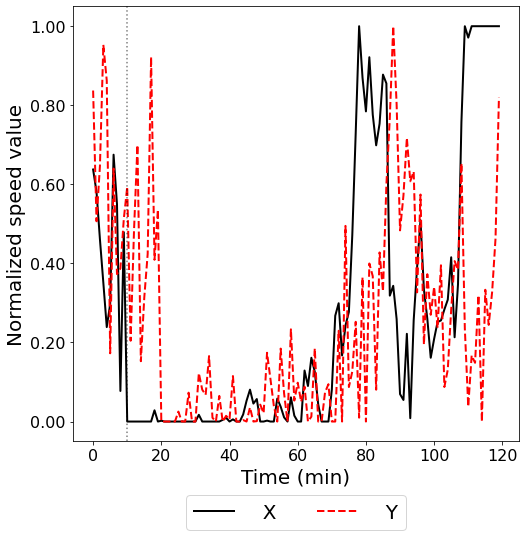

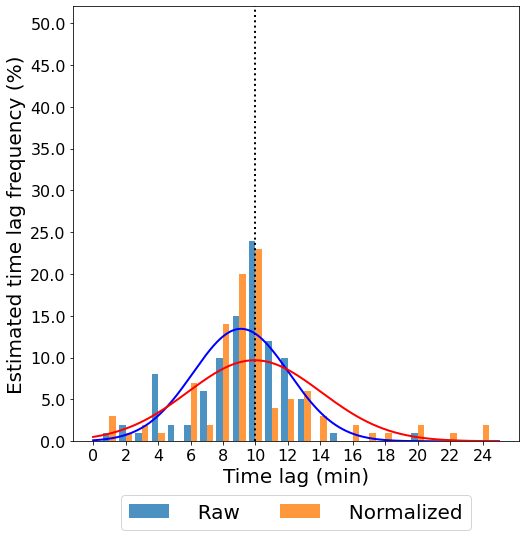

In [60]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_centering,y_centering, lag=lag, plot=True, 
                                                                              title = 'Centering with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [61]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [62]:
results.append(['center_p_30', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

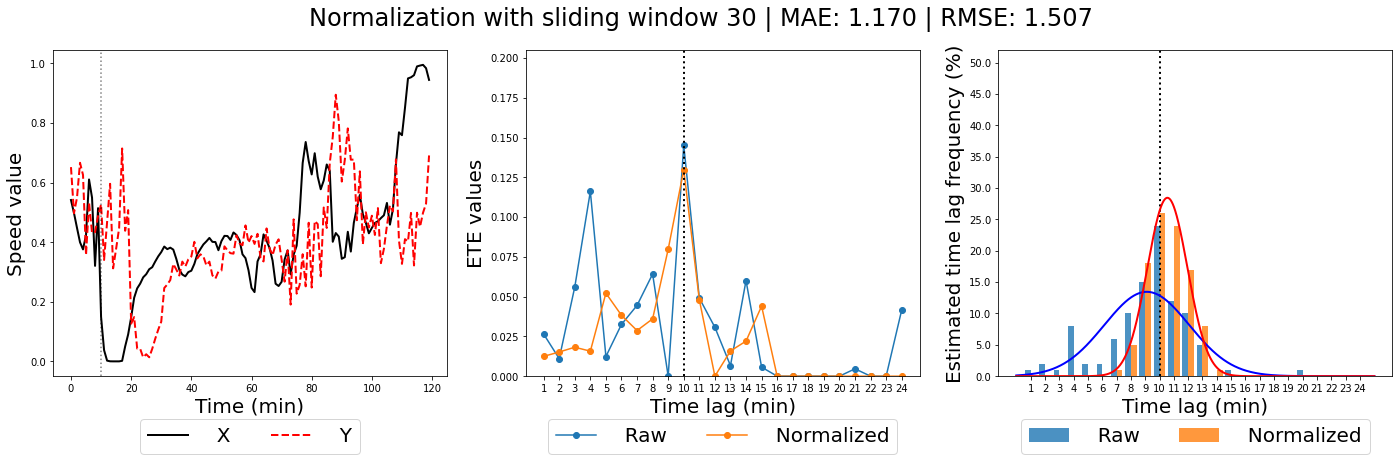

(10.55,
 1.17,
 1.5066519173319364,
 (10.179744477258106, 10.920255522741895),
 (10.55, 1.4026760139105536))

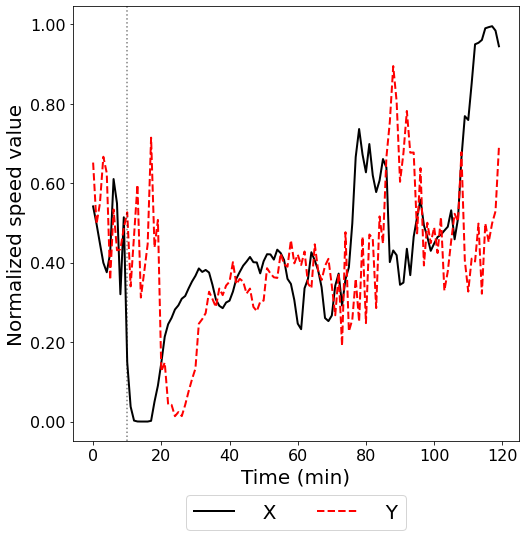

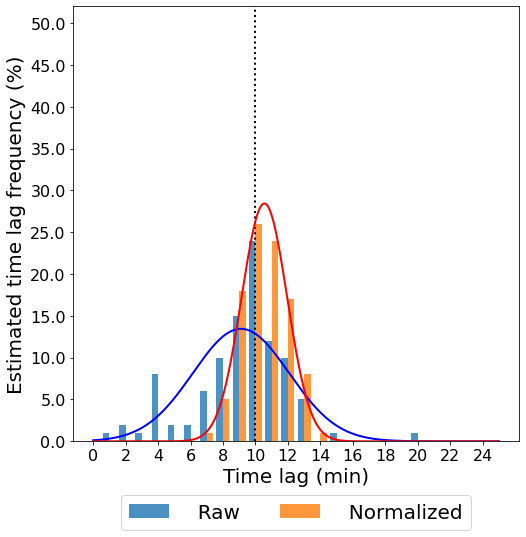

In [63]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_norm,y_norm, plot=True, lag=lag, 
                                                                              title = 'Normalization with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

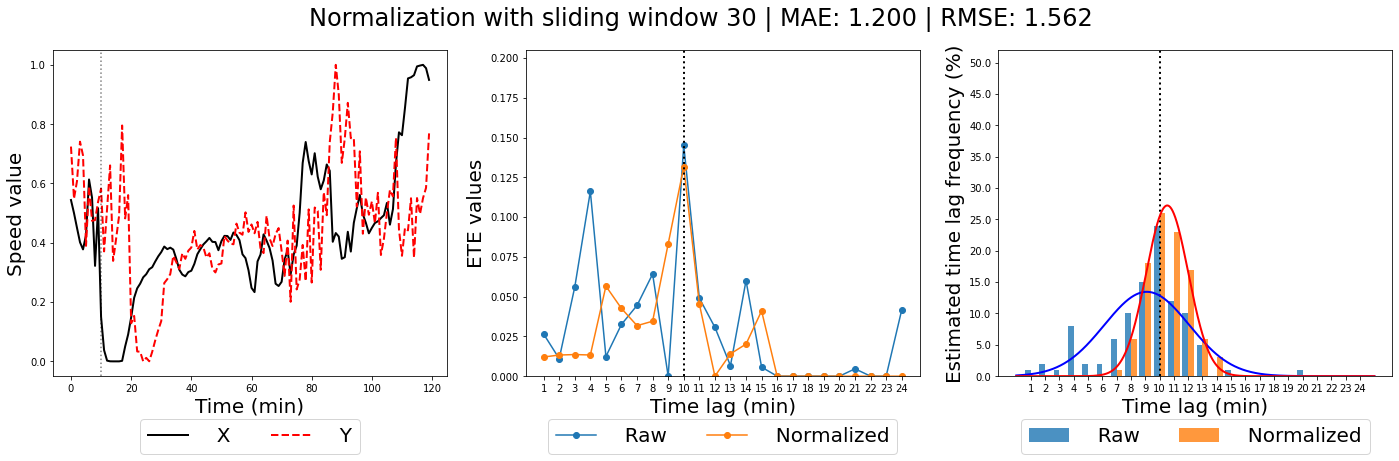

(10.54,
 1.2,
 1.5620499351813308,
 (10.153097312408786, 10.926902687591213),
 (10.54, 1.46574213284602))

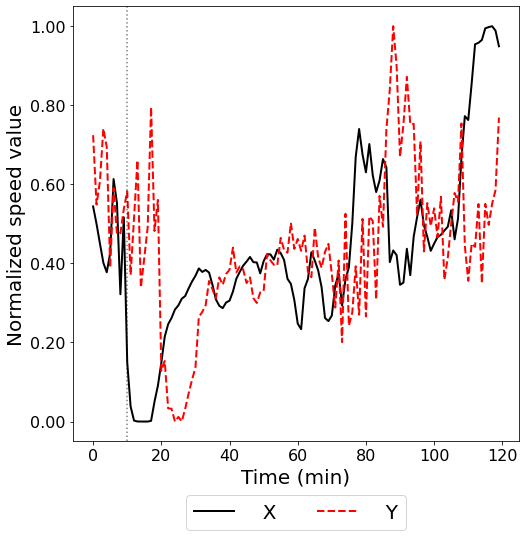

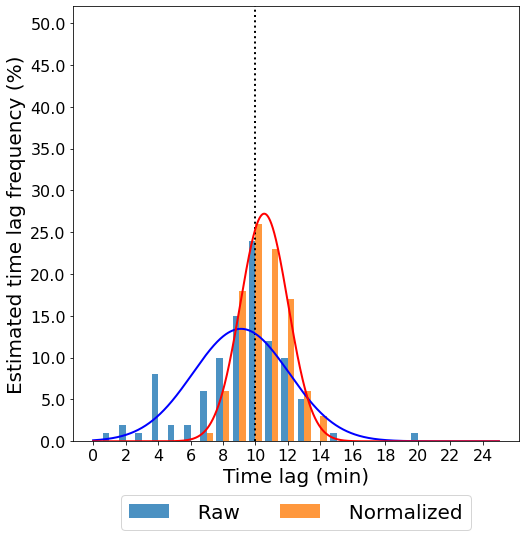

In [64]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                              title = 'Normalization with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [65]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [66]:
results.append(['norm_p_30', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

In [67]:
period=40

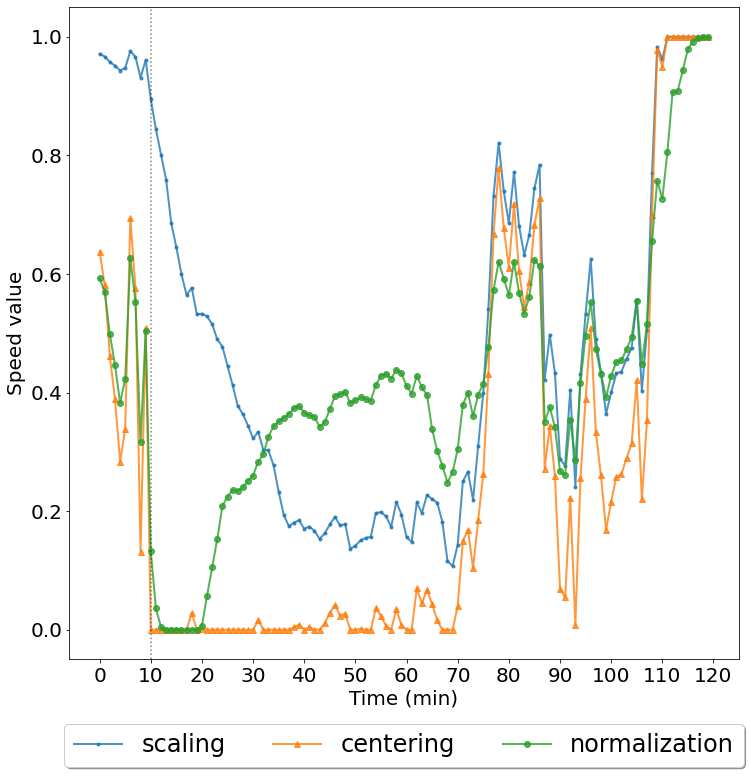

In [68]:
x_scaling = scaling(x, period=period)[-120:]
x_centering = centering(x, period=period)[-120:]
x_norm = normalization(x, period=period)[-120:]
x_norm_scaled = normalization(x, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(x_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(x_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(x_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=24)
plt.show()

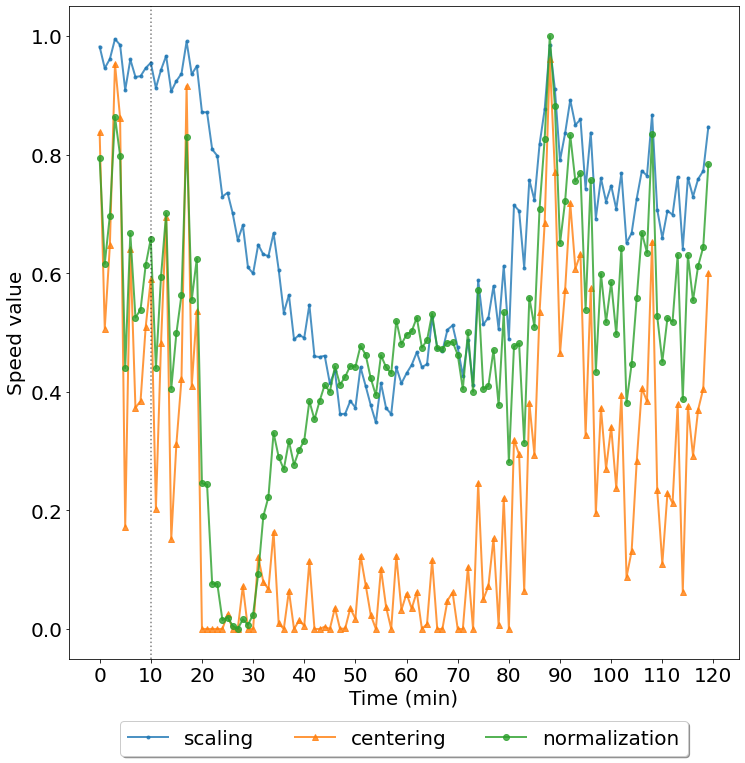

In [69]:
y_scaling = scaling(y, period=period)[-120:]
y_centering = centering(y, period=period)[-120:]
y_norm = normalization(y, period=period)[-120:]
y_norm_scaled = normalization(y, scale=True, period=period)[-120:]

fig, ax = plt.subplots(1, 1, figsize=(12,12))
# ax.plot(x, label='raw')
ax.plot(y_scaling.reset_index(drop=True), marker='.', label='scaling', lw=2, alpha=0.8)
ax.plot(y_centering.reset_index(drop=True), marker='^', label='centering', lw=2, alpha=0.8)
ax.plot(y_norm_scaled.reset_index(drop=True), marker='o', label='normalization', lw=2, alpha=0.8)
ax.axvline(10, color='k', ls = ':', alpha=0.5)
plt.xticks(np.arange(0, 120+1, 10), fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Speed value', fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=3, fontsize=20)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

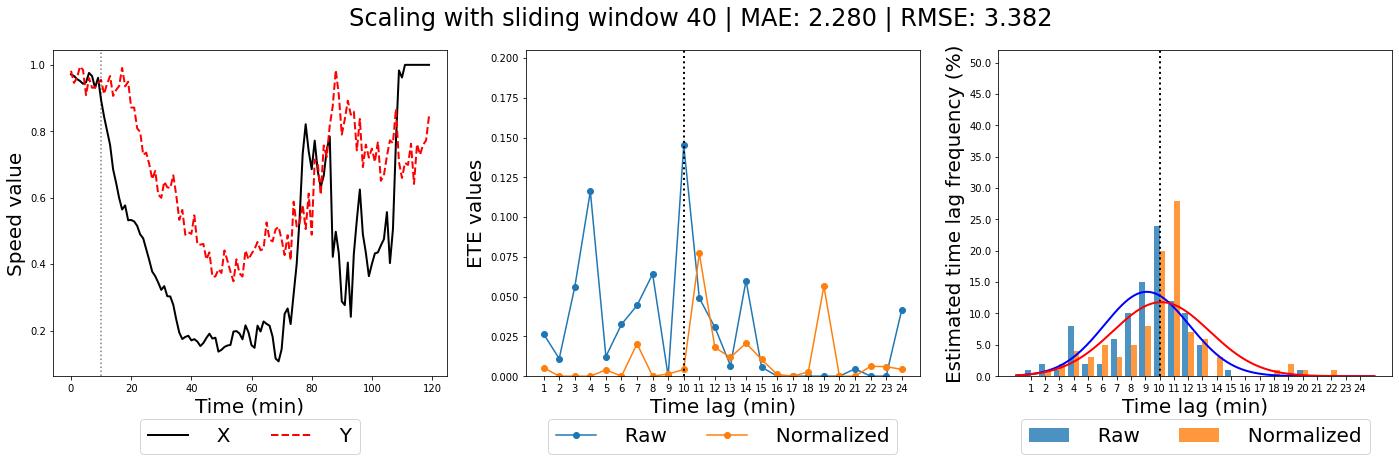

(10.12,
 2.28,
 3.3823069050575527,
 (9.22775590474023, 11.012244095259769),
 (10.12, 3.3801775101316798))

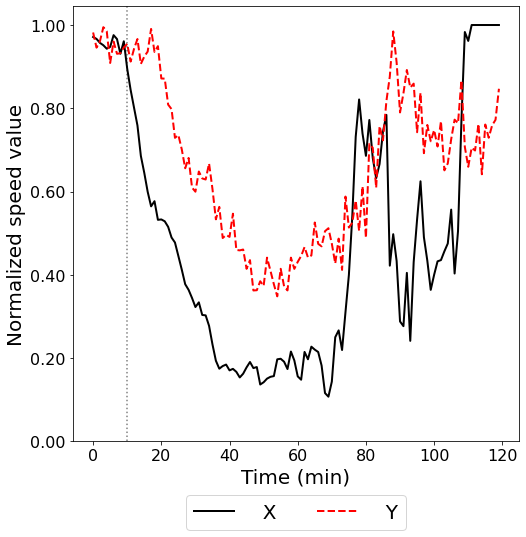

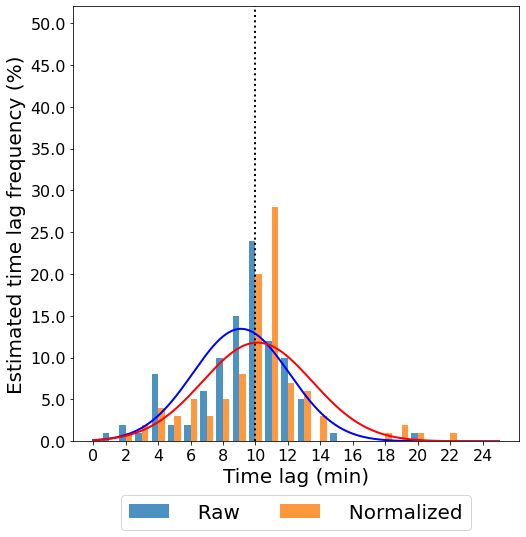

In [70]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_scaling,y_scaling, lag=lag, plot=True, 
                                                                              title = 'Scaling with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [71]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [72]:
results.append(['scale_p_40', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

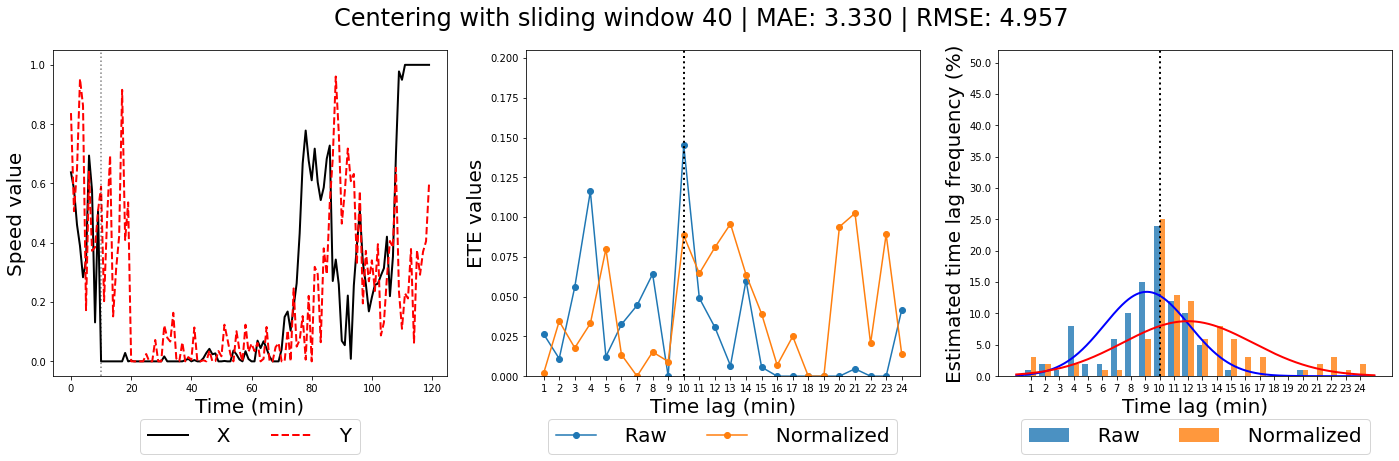

(11.97,
 3.33,
 4.956813492557492,
 (10.76935401183718, 13.170645988162821),
 (11.97, 4.548527234171519))

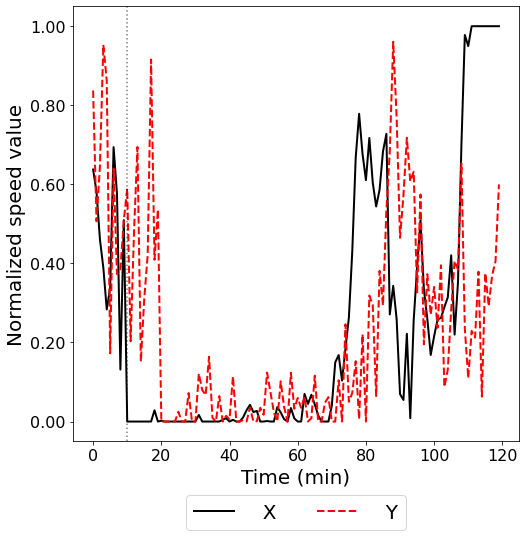

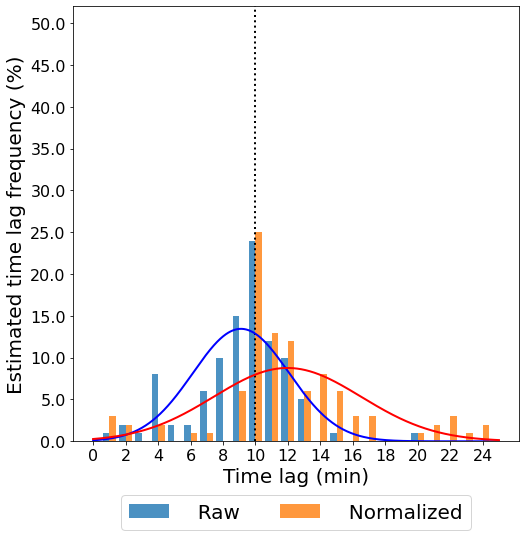

In [73]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_centering,y_centering, lag=lag, plot=True, 
                                                                              title = 'Centering with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [74]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [75]:
results.append(['center_p_40', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

  0%|          | 0/100 [00:00<?, ?it/s]

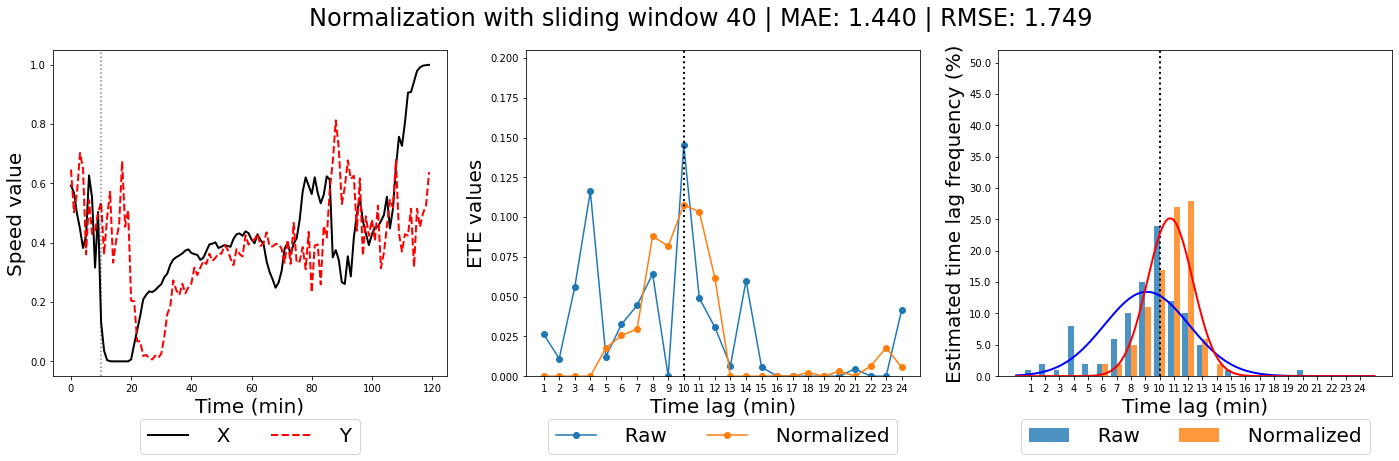

(10.74,
 1.44,
 1.7492855684535902,
 (10.321602995029874, 11.158397004970126),
 (10.74, 1.585055204085965))

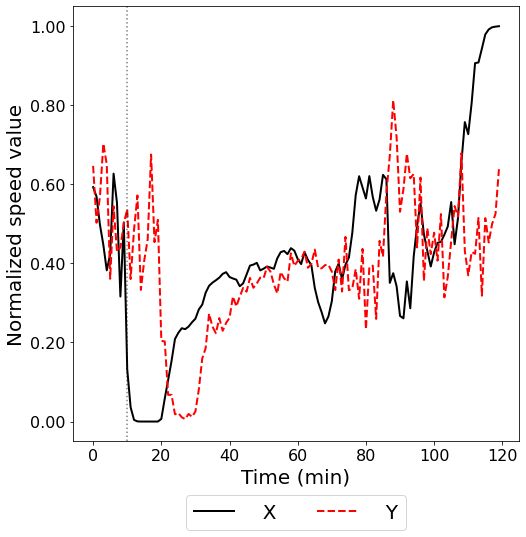

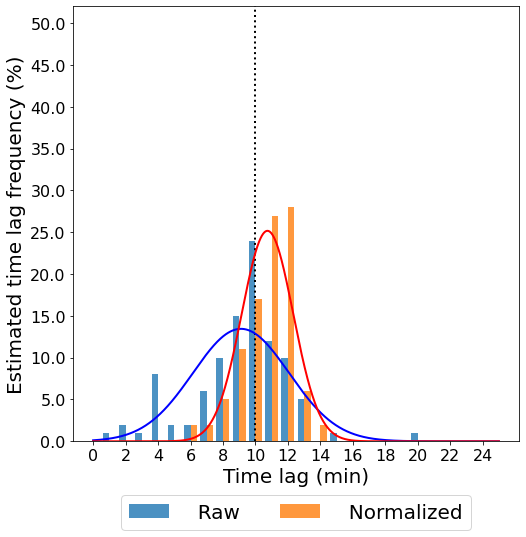

In [76]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_norm,y_norm, plot=True, lag=lag, 
                                                                              title = 'Normalization with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

  0%|          | 0/100 [00:00<?, ?it/s]

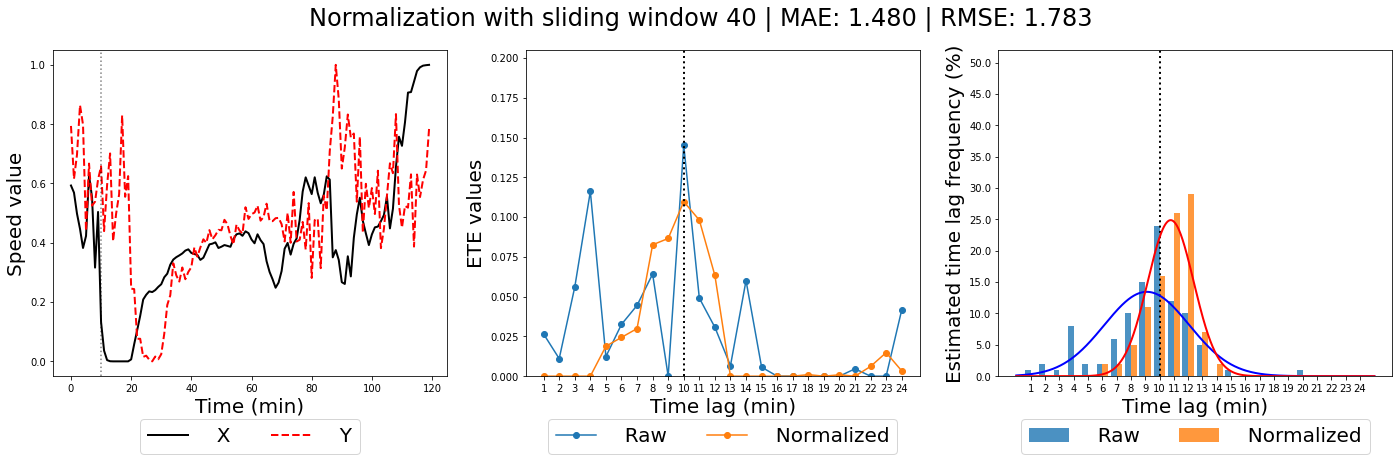

(10.78,
 1.48,
 1.783255450012701,
 (10.356702324863603, 11.203297675136396),
 (10.78, 1.6036209028320876))

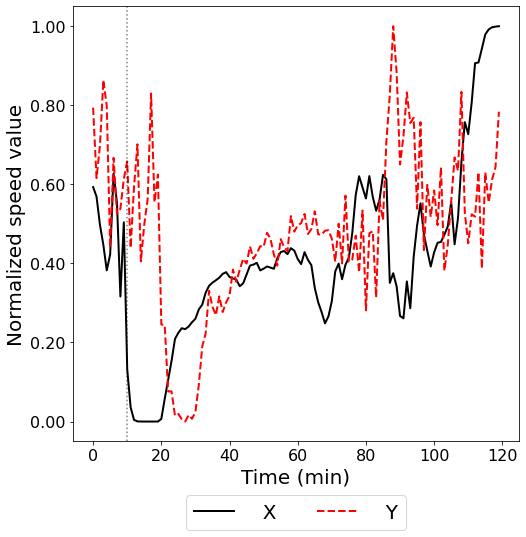

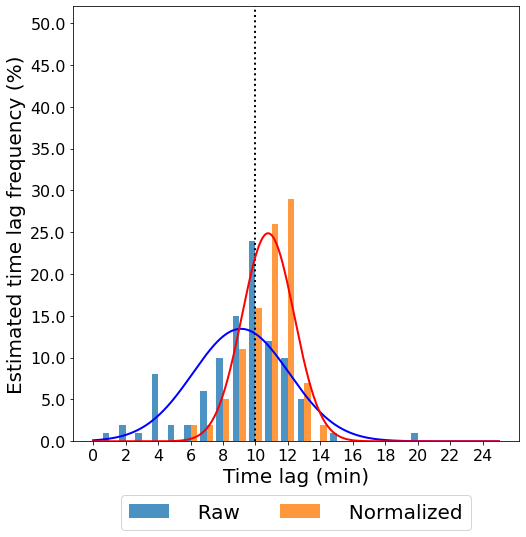

In [77]:
TE_lag, ETE_value, TE_boot_lag, TE_boot_count, TE_boot_mean, curve = get_boot(x_norm_scaled,y_norm_scaled, lag=lag, plot=True, 
                                                                              title = 'Normalization with sliding window {}'.format(period), raw=raw, curve=True)
TE_boot_mean, get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), get_bound(TE_boot_count, confidence=0.99), curve[2]

In [78]:
TE_boot = [[val] * TE_boot_count[val]  for val in TE_boot_count.keys()]
TE_boot = np.array([x for y in TE_boot for x in y])

In [79]:
results.append(['norm_p_40', TE_boot.mean(), TE_boot.std(), get_mae(TE_boot_count, lag), get_rmse(TE_boot_count, lag), 
                *get_bound(TE_boot_count, confidence=0.99), *curve[2]])

In [80]:
results = pd.DataFrame(results)
results = results.sort_values(0)

In [81]:
results.to_csv('results.csv')